In [1]:
!pip install git+https://github.com/ia-ML/segmentation_models

  Cloning https://github.com/ia-ML/segmentation_models to /tmp/pip-req-build-41rrjmuz
  Running command git clone --filter=blob:none --quiet https://github.com/ia-ML/segmentation_models /tmp/pip-req-build-41rrjmuz
  Resolved https://github.com/ia-ML/segmentation_models to commit 6c9a4cd0193291157e90df1945f4b0714a5d55fb
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=34263 sha256=8929a04fa4a5f82e55f879711671c28cc87d0852ac4776cd4c2ad62b8c8a8f79
  Stored in directory: /tmp/pip-ephem-wheel-cache-t3e3doy3/wheels/b9/9c/ad/941476e5a2d98a5e44c163e15f43abbff888a159dbedbf1be3
Successfully built segmentation_models


In [2]:
# https://github.com/ia-ML/segmentation_models
import os
import keras
import numpy as np
from glob import glob
import pandas as pd
import tensorflow as tf
from keras.metrics import *
import matplotlib.pyplot as plt
import segmentation_models as sm
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

selector = 0
EPOCHS   = 250

2024-06-22 05:57:50.603489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 05:57:50.603585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 05:57:50.736792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [3]:
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Sat Jun 22 05:58:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
n_classes   = 5
IMG_HEIGHT  = 256
IMG_WIDTH   = 256
BATCH_SIZE  = 16
BACKBONE    = 'vgg16'
class_names = [0, 1, 2, 3, 4]
seed        = 42
tf.random.set_seed(seed=42)

In [5]:
keras.backend.set_image_data_format('channels_last') # mirar si se tiene que cambiar por tf.keras

In [6]:
current_path = '/kaggle/working/'
data_path = '/kaggle/input/maestria-dataset-npy/02 - Denoised' # cambiar esta por el input

print(current_path)
print(data_path)

/kaggle/working/
/kaggle/input/maestria-dataset-npy/02 - Denoised


In [7]:
n_classes   = 5
IMG_HEIGHT  = 256
IMG_WIDTH   = 256
BATCH_SIZE  = 32

class_names = [0, 1, 2, 3, 4]
seed        = 42
tf.random.set_seed(seed=42)

In [8]:
def parse_image_and_mask(image_path, mask_path):
    # Convert tensor to string
    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')

    # Load the image
    image = np.load(image_path)
    image = np.expand_dims(image, axis=-1)  # Add a channel dimension
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Load the mask
    mask = np.load(mask_path)
    mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension
    mask = tf.convert_to_tensor(mask, dtype=tf.int32)
    mask = tf.squeeze(mask, axis=-1)  # Remove the extra channel dimension
    mask = tf.one_hot(mask, depth=n_classes)  # Depth is 5 for classes 0 to 4
    
    return image, mask

def parse_image_and_mask_tf(image_path, mask_path):
    image, mask = tf.py_function(parse_image_and_mask, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, n_classes])
    return image, mask

def create_dataset(image_paths, mask_paths):
    # Create a dataset of image and mask paths
    path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    return path_dataset.map(
        parse_image_and_mask_tf, num_parallel_calls=tf.data.AUTOTUNE
    )

In [9]:
image_paths = sorted(glob(os.path.join(data_path, "train/ims/*")))
mask_paths  = sorted(glob(os.path.join(data_path, "train/masks/*")))
train_ds    = create_dataset(image_paths, mask_paths)

image_paths = sorted(glob(os.path.join(data_path, "test/ims/*")))
mask_paths  = sorted(glob(os.path.join(data_path, "test/masks/*")))
valid_ds    = create_dataset(image_paths, mask_paths)

In [10]:
def plot_example(image, mask, pred=None,name=None):
    plt.figure(figsize=(20, 10))
    ncols = n_classes
    nrows = 2 if pred is None else 3

    # plot image
    plt.subplot(nrows, ncols, 1)
    #plt.imshow(image[..., 0], cmap='gray')  # Show single channel image
    plt.imshow(image)
    plt.title(name)
    plt.axis("off")

    # plot each channel in mask
    for i in range(n_classes):
        mask_channel = mask[..., i]
        plt.subplot(nrows, ncols, i+n_classes+1)
        #plt.imshow(mask_channel, cmap='gray')  # Show single channel mask
        plt.imshow(mask_channel)
        plt.title(f"Mask, {class_names[i]}")
        plt.axis("off")

    # plot each channel in prediction
    if pred is not None:
        for i in range(n_classes):
            mask_channel = pred[..., i]
            plt.subplot(nrows, ncols, i+n_classes*2+1)
            plt.imshow(mask_channel, cmap='gray')  # Show single channel prediction
            plt.title(f"Prediction, {class_names[i]}")
            plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"{name}.png")
    plt.show()

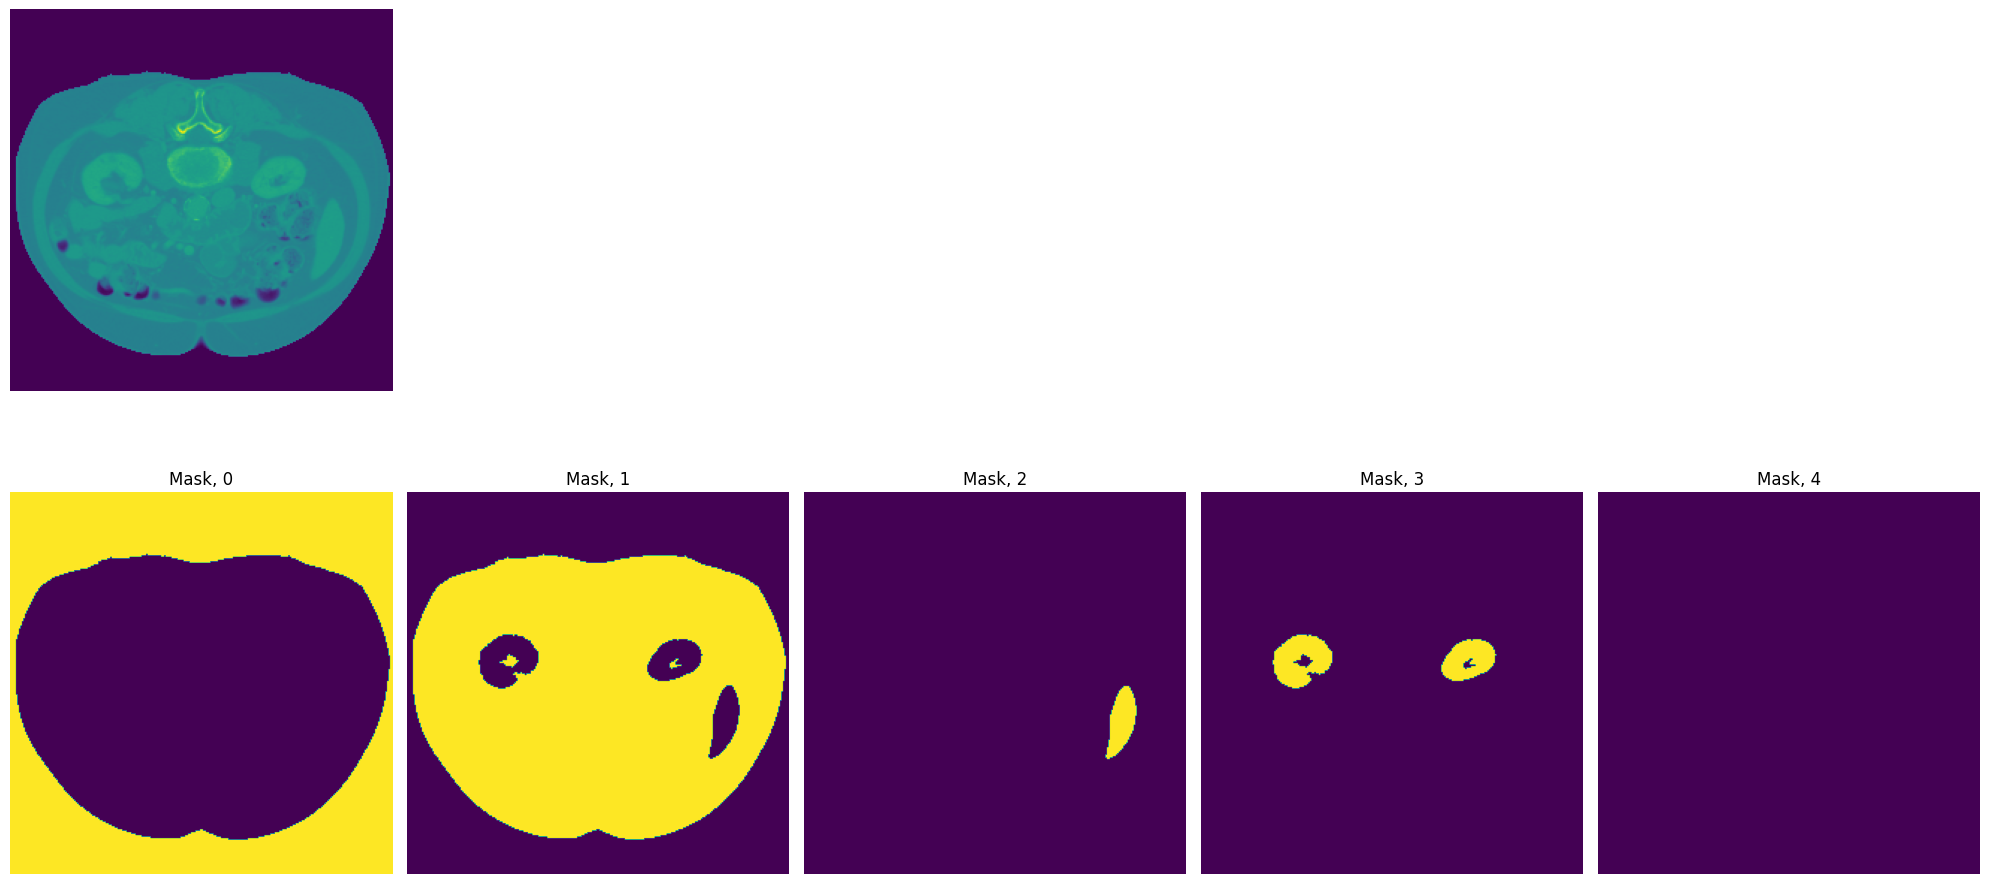

(256, 256, 1) (256, 256, 5)


In [11]:
image, mask = next(iter(train_ds))
plot_example(image, mask)

print(image.shape, mask.shape)

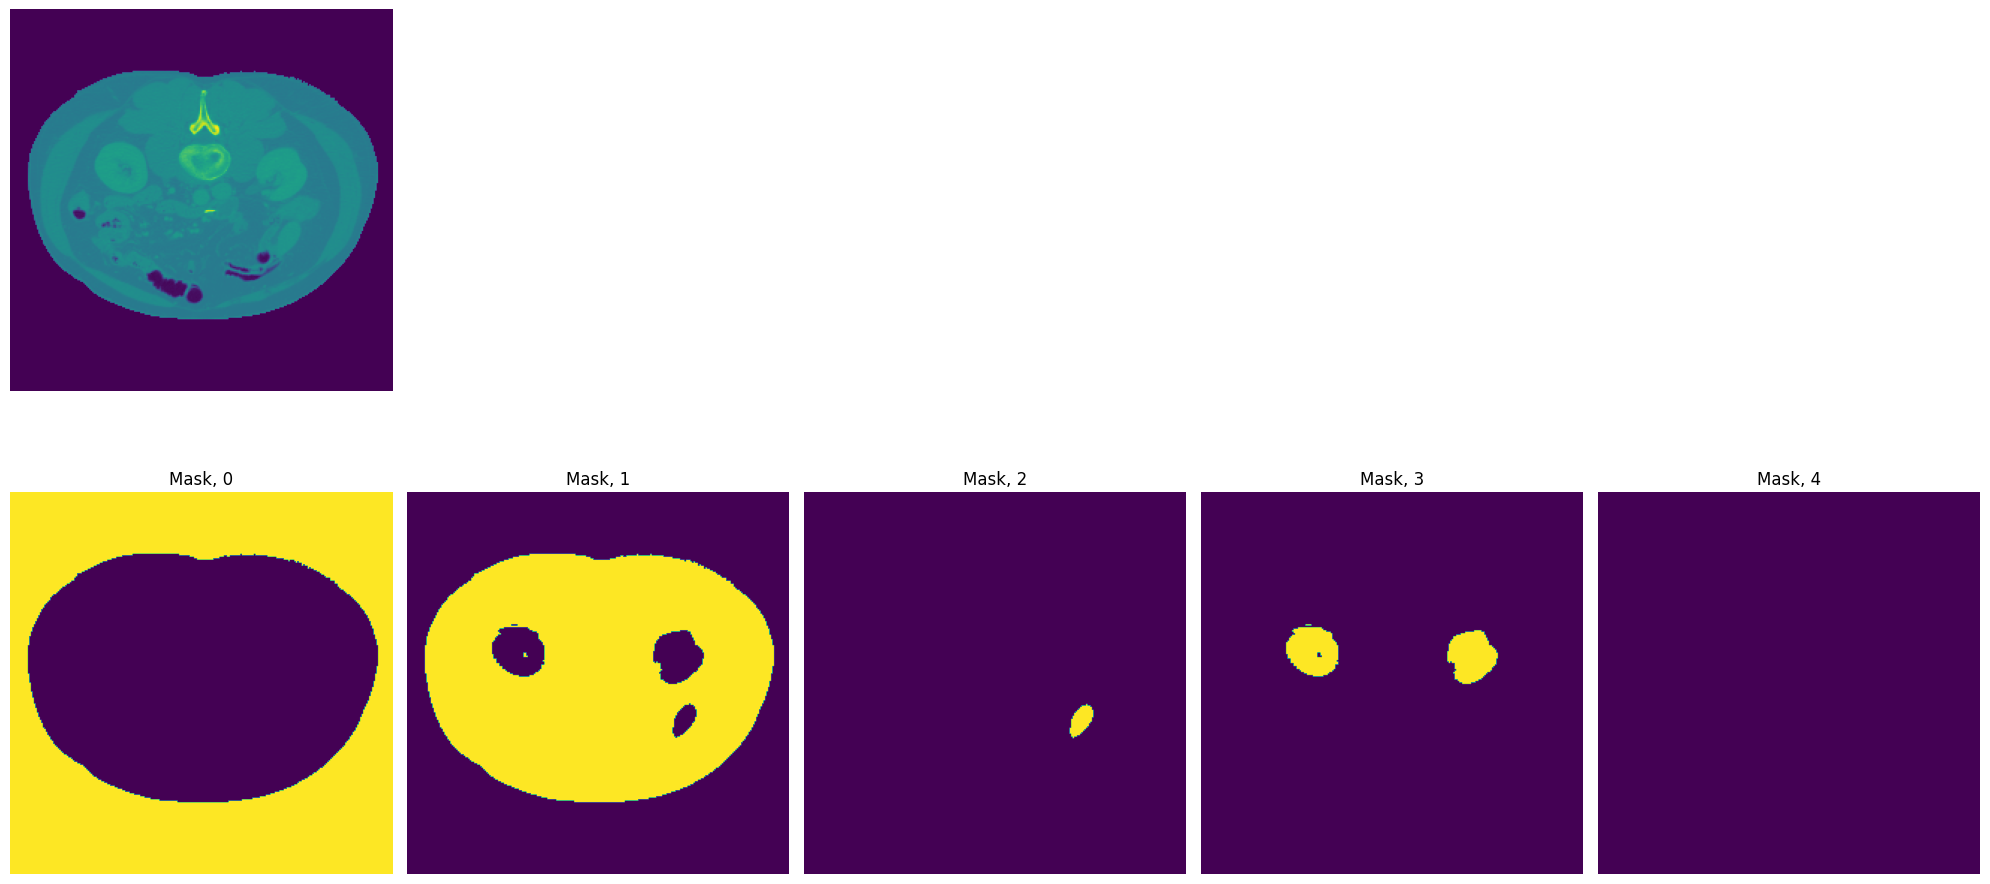

(256, 256, 1) (256, 256, 5)


In [12]:
image, mask = next(iter(valid_ds))
plot_example(image, mask)

print(image.shape, mask.shape)

In [13]:
train_ds = train_ds.shuffle(buffer_size=1000, seed=seed) \
                   .cache() \
                   .batch(batch_size=BATCH_SIZE) \
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(batch_size=BATCH_SIZE) \
               .cache() \
               .prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# example batch
ib, mb = next(iter(train_ds))
ib.shape, mb.shape

(TensorShape([32, 256, 256, 1]), TensorShape([32, 256, 256, 5]))

In [15]:
if selector == 0:
    model = sm.Unet(BACKBONE, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), classes=n_classes, activation='softmax',encoder_weights=None)
    name_model = "unet"
elif selector == 1:
    model = sm.PSPNet(BACKBONE, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), classes=n_classes, activation='softmax',encoder_weights=None)
    name_model = "PSPNet"
elif selector == 2:
    model = sm.FPN(BACKBONE, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), classes=n_classes, activation='softmax',encoder_weights=None)
    name_model = "FPN"
elif selector == 3:
    model = sm.Linknet(BACKBONE, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), classes=n_classes, activation='softmax',encoder_weights=None)
    name_model = "Linknet"

name_checkpoint = f'{current_path}/{name_model}_5_classes.keras'

keras_metrics = ['accuracy',
                  sm.metrics.iou_score,
                  sm.metrics.dice_score,
                  sm.metrics.f1_score,
                  sm.metrics.f2_score,
                  sm.metrics.precision,
                  sm.metrics.recall,
                  ]

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=keras_metrics)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 23,751,701 (90.61 MB)

 Trainable params: 23,747,669 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [16]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    to_file=f'{current_path}/{name_model}.png',
)

In [17]:
checkpoint_path = name_checkpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_freq='epoch',
    )
]

# train
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/250


2024-06-22 05:58:36.351569: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 1.05936, expected 0.681349
2024-06-22 05:58:36.351624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 2.21753, expected 1.83952
2024-06-22 05:58:36.351634: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 2.5462, expected 2.16819
2024-06-22 05:58:36.351643: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 2.07291, expected 1.6949
2024-06-22 05:58:36.351651: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 2.56529, expected 2.18728
2024-06-22 05:58:36.351659: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 2.19261, expected 1.8146
2024-06-22 05:58:36.351668: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 1.83463, expected 1.45662
2024-06-22 05:58:36.351676: E

85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8064 - dice_score: 0.3554 - f1-score: 0.3554 - f2-score: 0.3550 - iou_score: 0.2791 - loss: 0.5853 - precision: 0.3759 - recall: 0.3853

2024-06-22 06:00:34.107566: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.06306, expected 0.587185
2024-06-22 06:00:34.107639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.37522, expected 1.89934
2024-06-22 06:00:34.107651: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.49553, expected 2.01965
2024-06-22 06:00:34.107665: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.35389, expected 1.87801
2024-06-22 06:00:34.107684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.81771, expected 2.34183
2024-06-22 06:00:34.107696: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.83996, expected 2.36408
2024-06-22 06:00:34.107706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.48233, expected 2.00645
2024-06-22 06:00:34.107717: E external/local_xla/xla/s

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.8074 - dice_score: 0.3564 - f1-score: 0.3564 - f2-score: 0.3560 - iou_score: 0.2801 - loss: 0.5823 - precision: 0.3768 - recall: 0.3861

2024-06-22 06:01:03.103010: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.28514, expected 0.771578
2024-06-22 06:01:03.103067: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.1253, expected 1.61173
2024-06-22 06:01:03.103077: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.51833, expected 2.00477
2024-06-22 06:01:03.103085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.3986, expected 1.88504
2024-06-22 06:01:03.103092: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.46482, expected 1.95126
2024-06-22 06:01:03.103100: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.79566, expected 2.2821
2024-06-22 06:01:03.103107: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.5201, expected 2.00653
2024-06-22 06:01:03.103114: E external/local_xla/xla/servi

86/86 ━━━━━━━━━━━━━━━━━━━━ 170s 874ms/step - accuracy: 0.8084 - dice_score: 0.3574 - f1-score: 0.3574 - f2-score: 0.3570 - iou_score: 0.2811 - loss: 0.5795 - precision: 0.3777 - recall: 0.3869 - val_accuracy: 0.8518 - val_dice_score: 0.4178 - val_f1-score: 0.4178 - val_f2-score: 0.4119 - val_iou_score: 0.3466 - val_loss: 0.4676 - val_precision: 0.4593 - val_recall: 0.4260
Epoch 2/250
86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 410ms/step - accuracy: 0.9451 - dice_score: 0.5470 - f1-score: 0.5470 - f2-score: 0.5469 - iou_score: 0.4752 - loss: 0.1566 - precision: 0.5496 - recall: 0.5475 - val_accuracy: 0.8700 - val_dice_score: 0.4314 - val_f1-score: 0.4314 - val_f2-score: 0.4259 - val_iou_score: 0.3678 - val_loss: 0.4193 - val_precision: 0.4948 - val_recall: 0.4401
Epoch 3/250
86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 410ms/step - accuracy: 0.9511 - dice_score: 0.5756 - f1-score: 0.5756 - f2-score: 0.5754 - iou_score: 0.5044 - loss: 0.1314 - precision: 0.5778 - recall: 0.5758 - val_accuracy: 0.8827 - val_dice_s

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


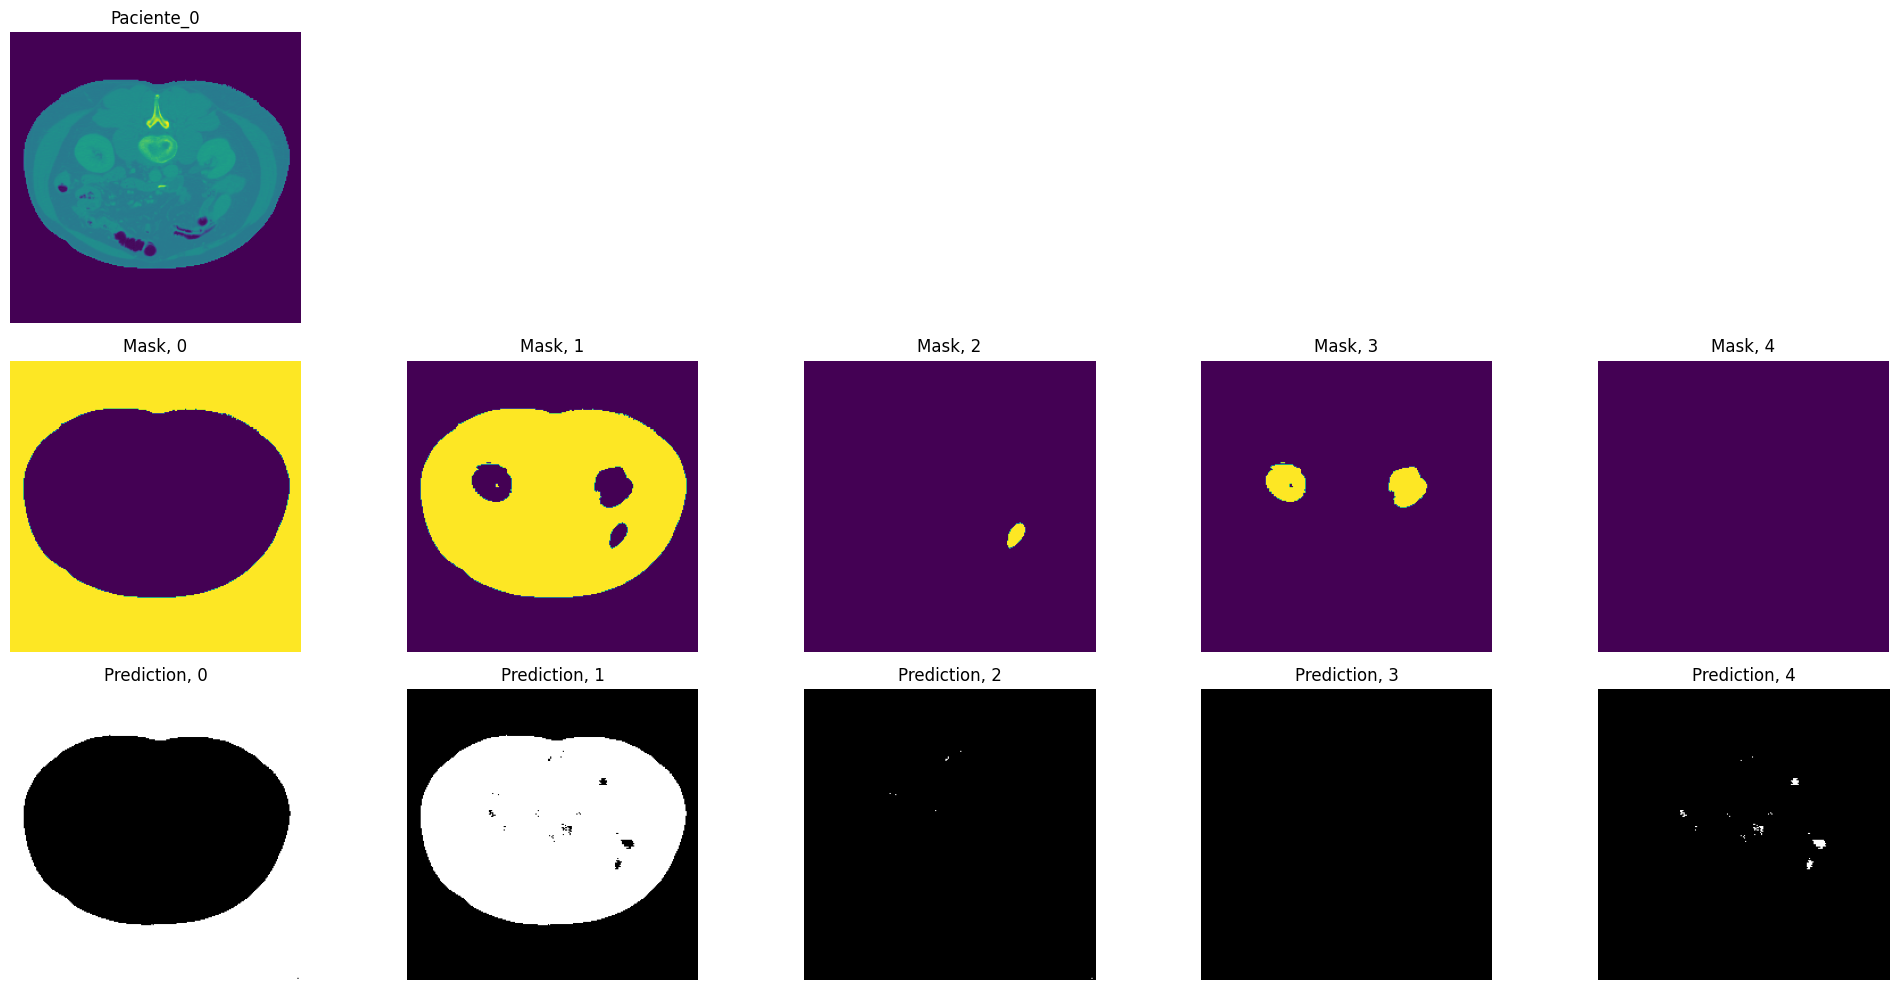

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


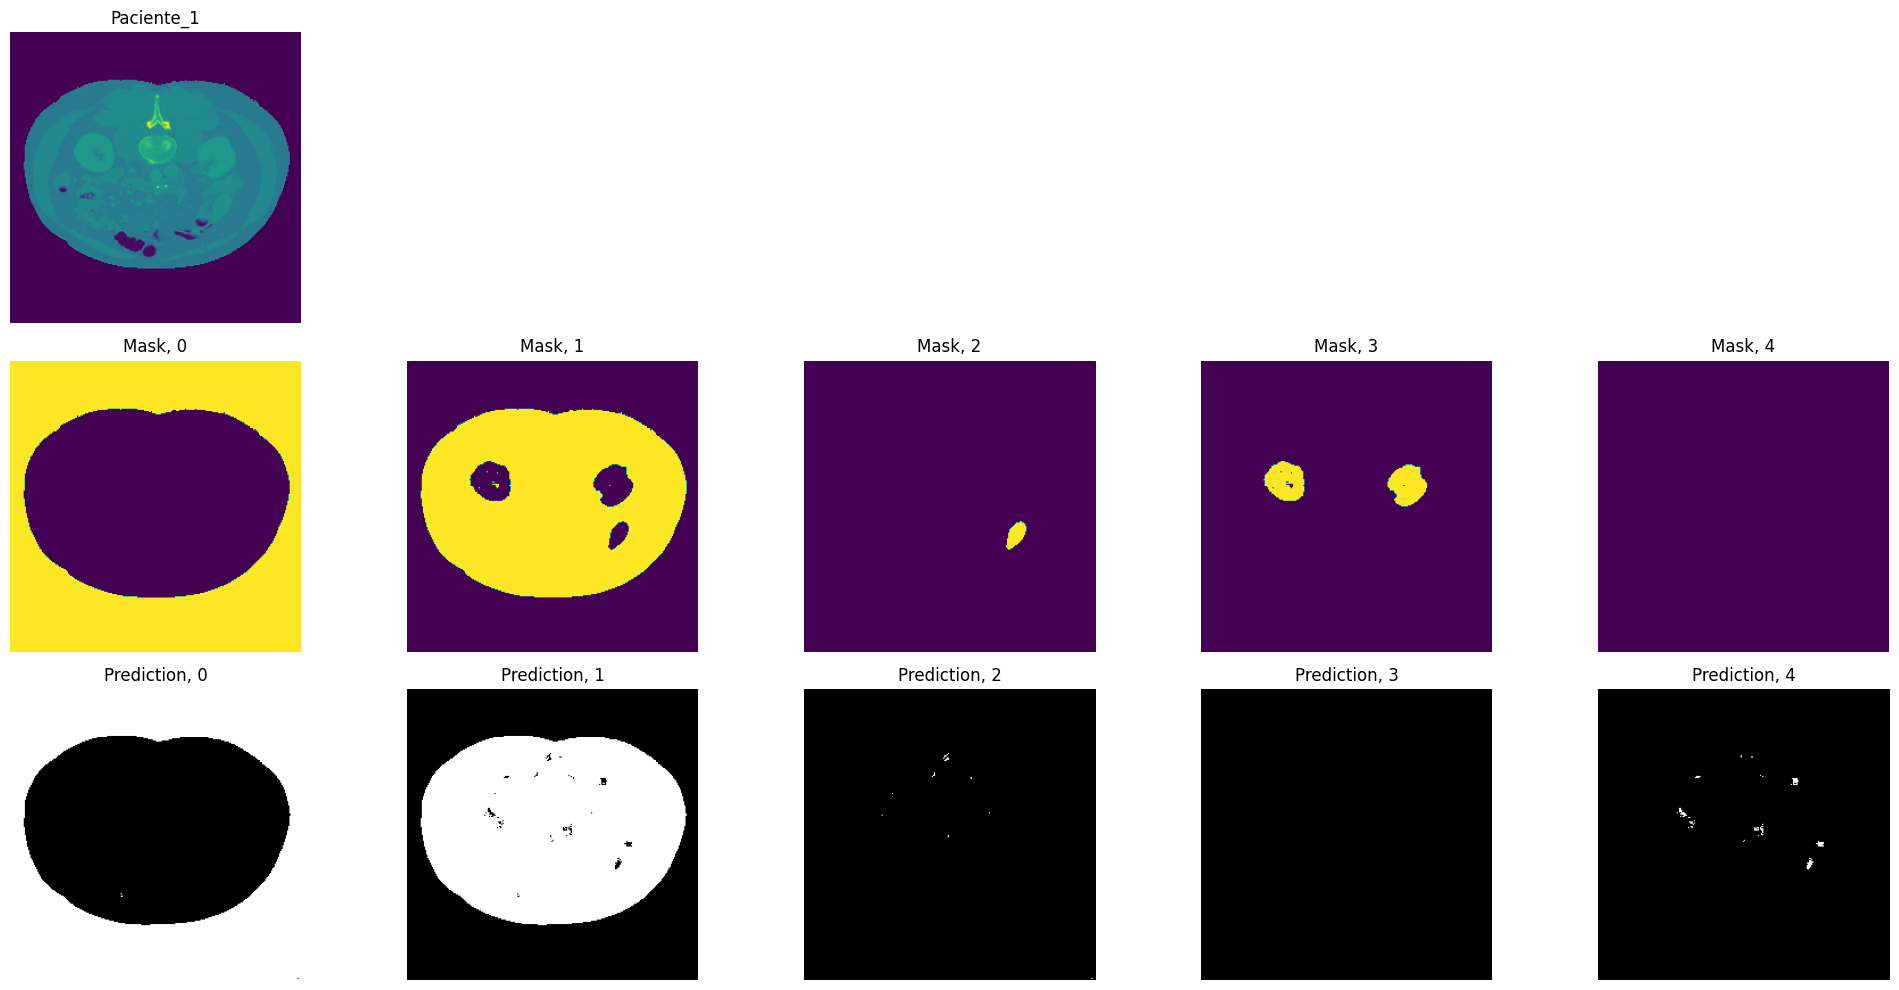

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


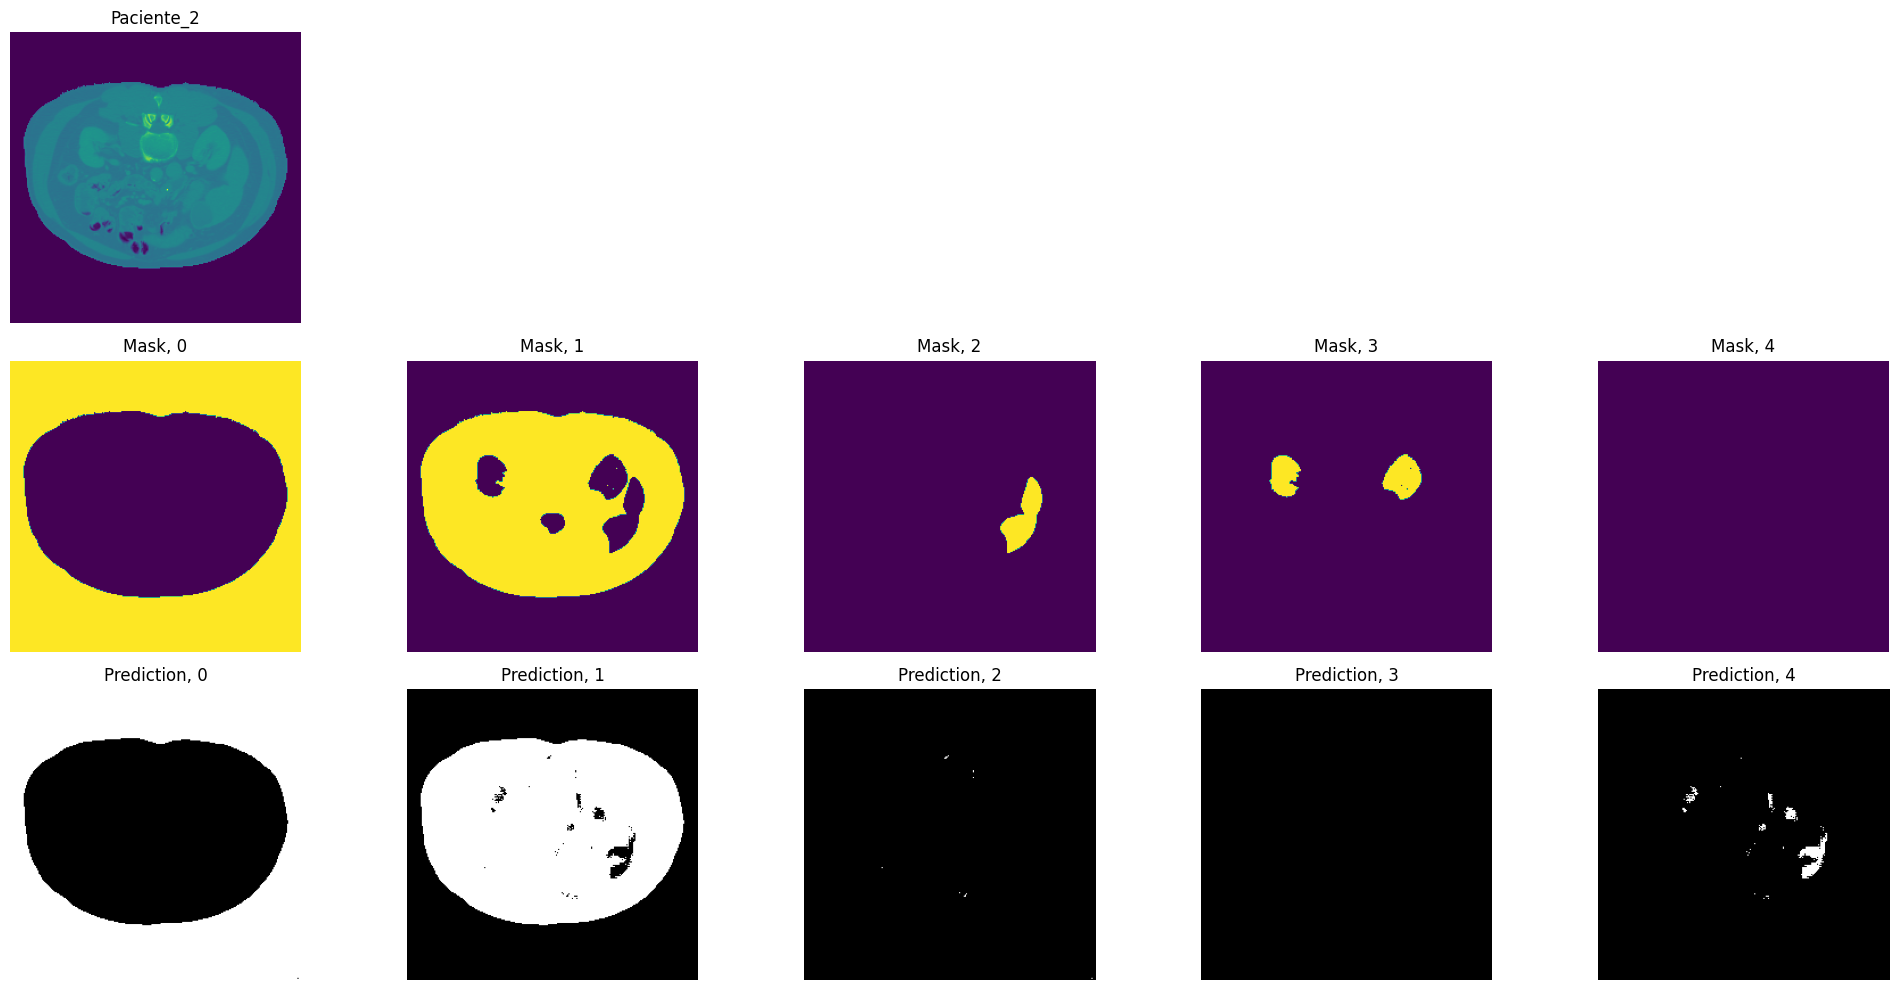

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


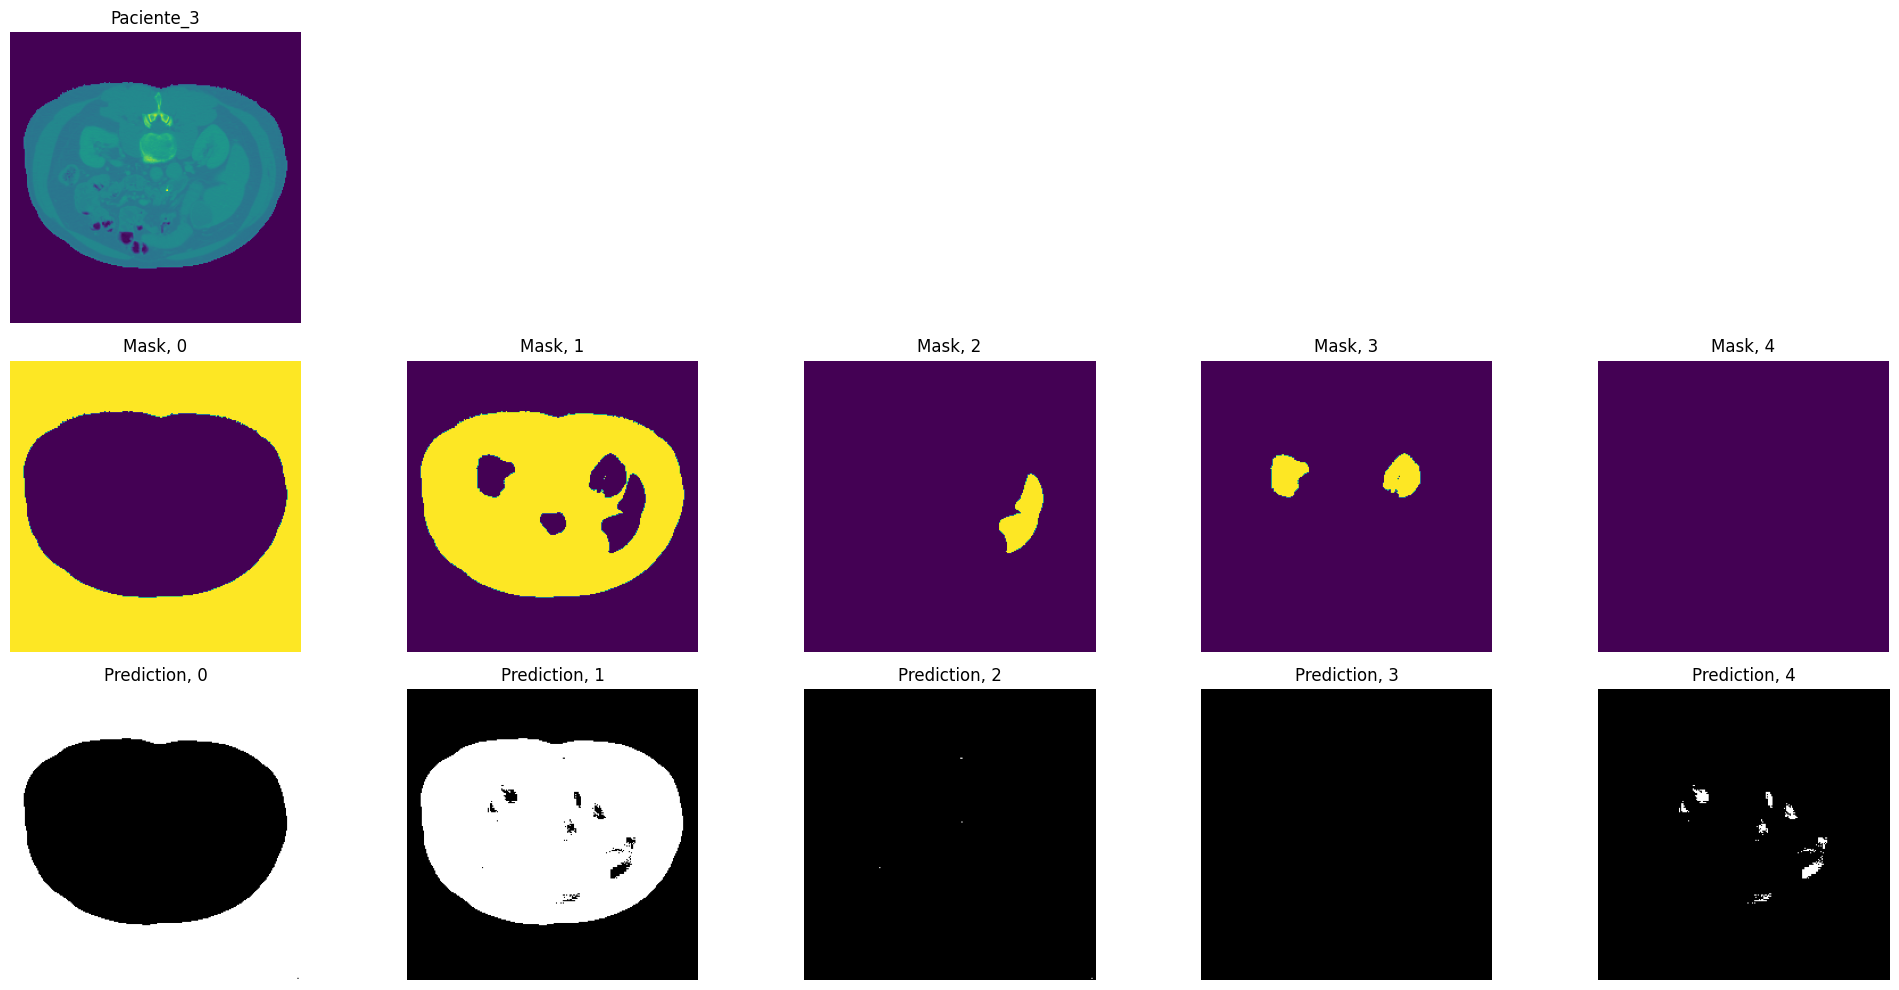

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


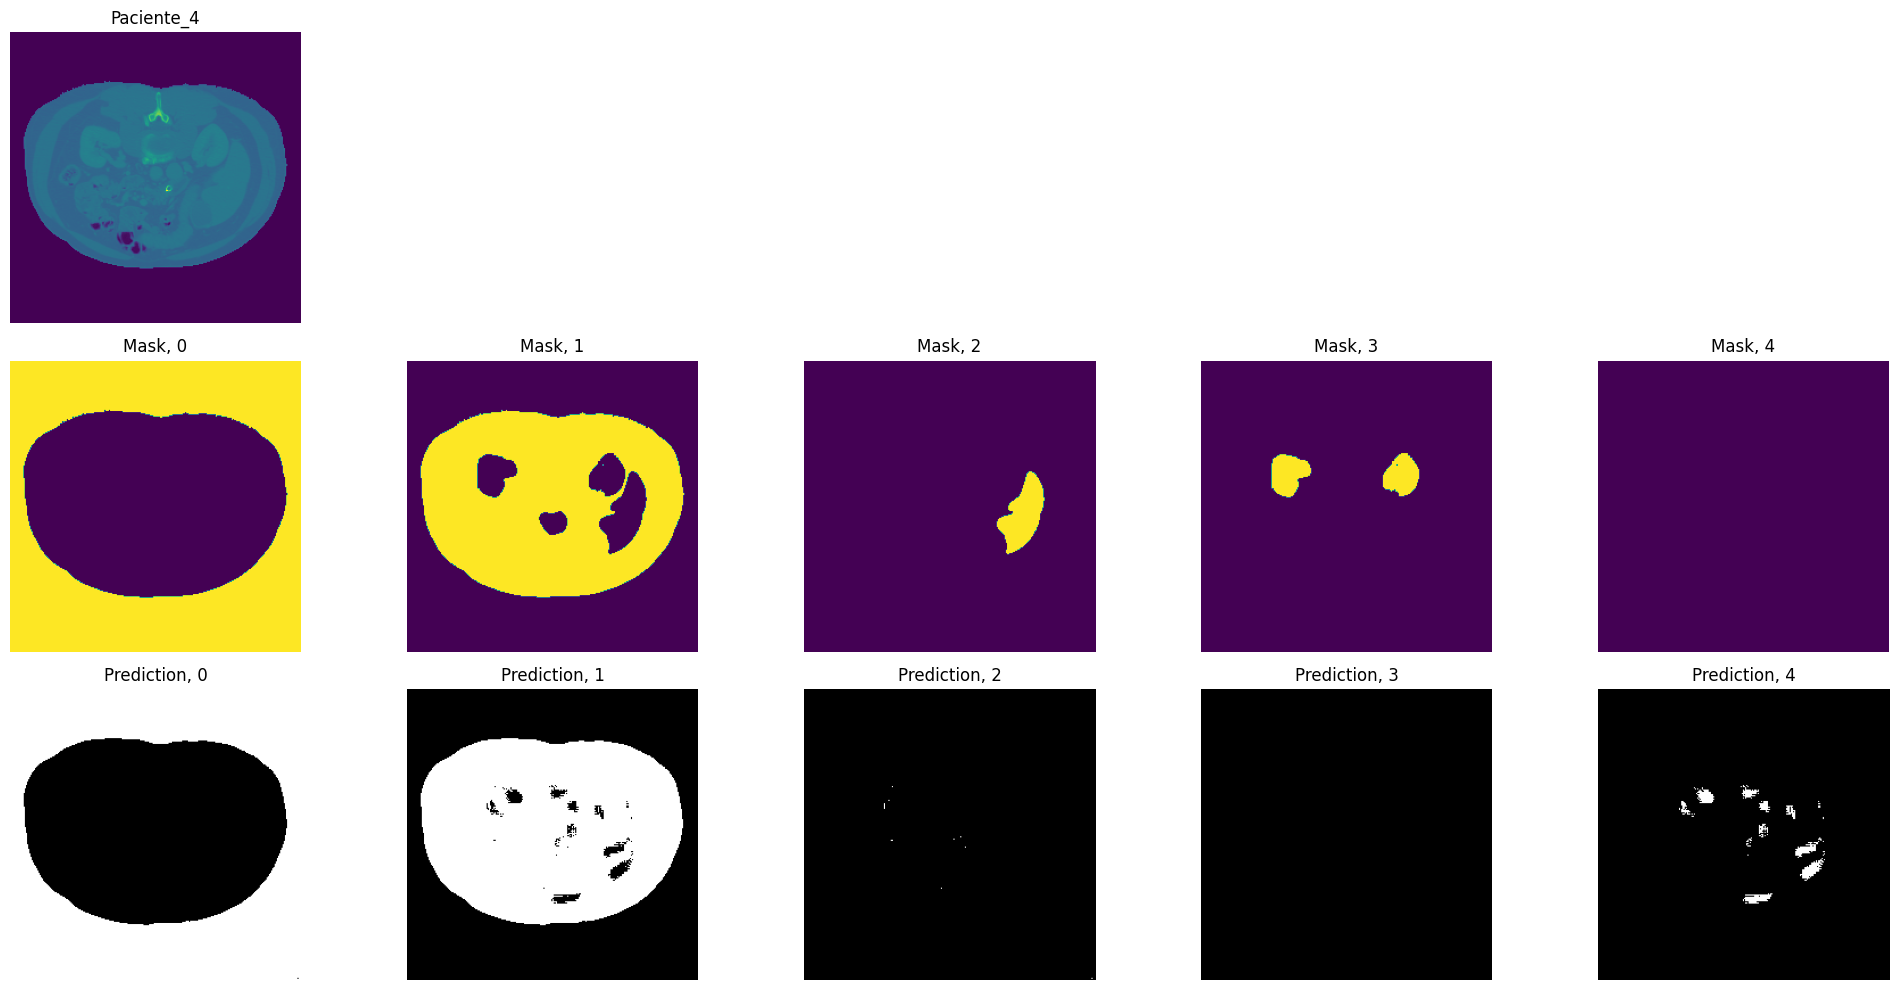

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


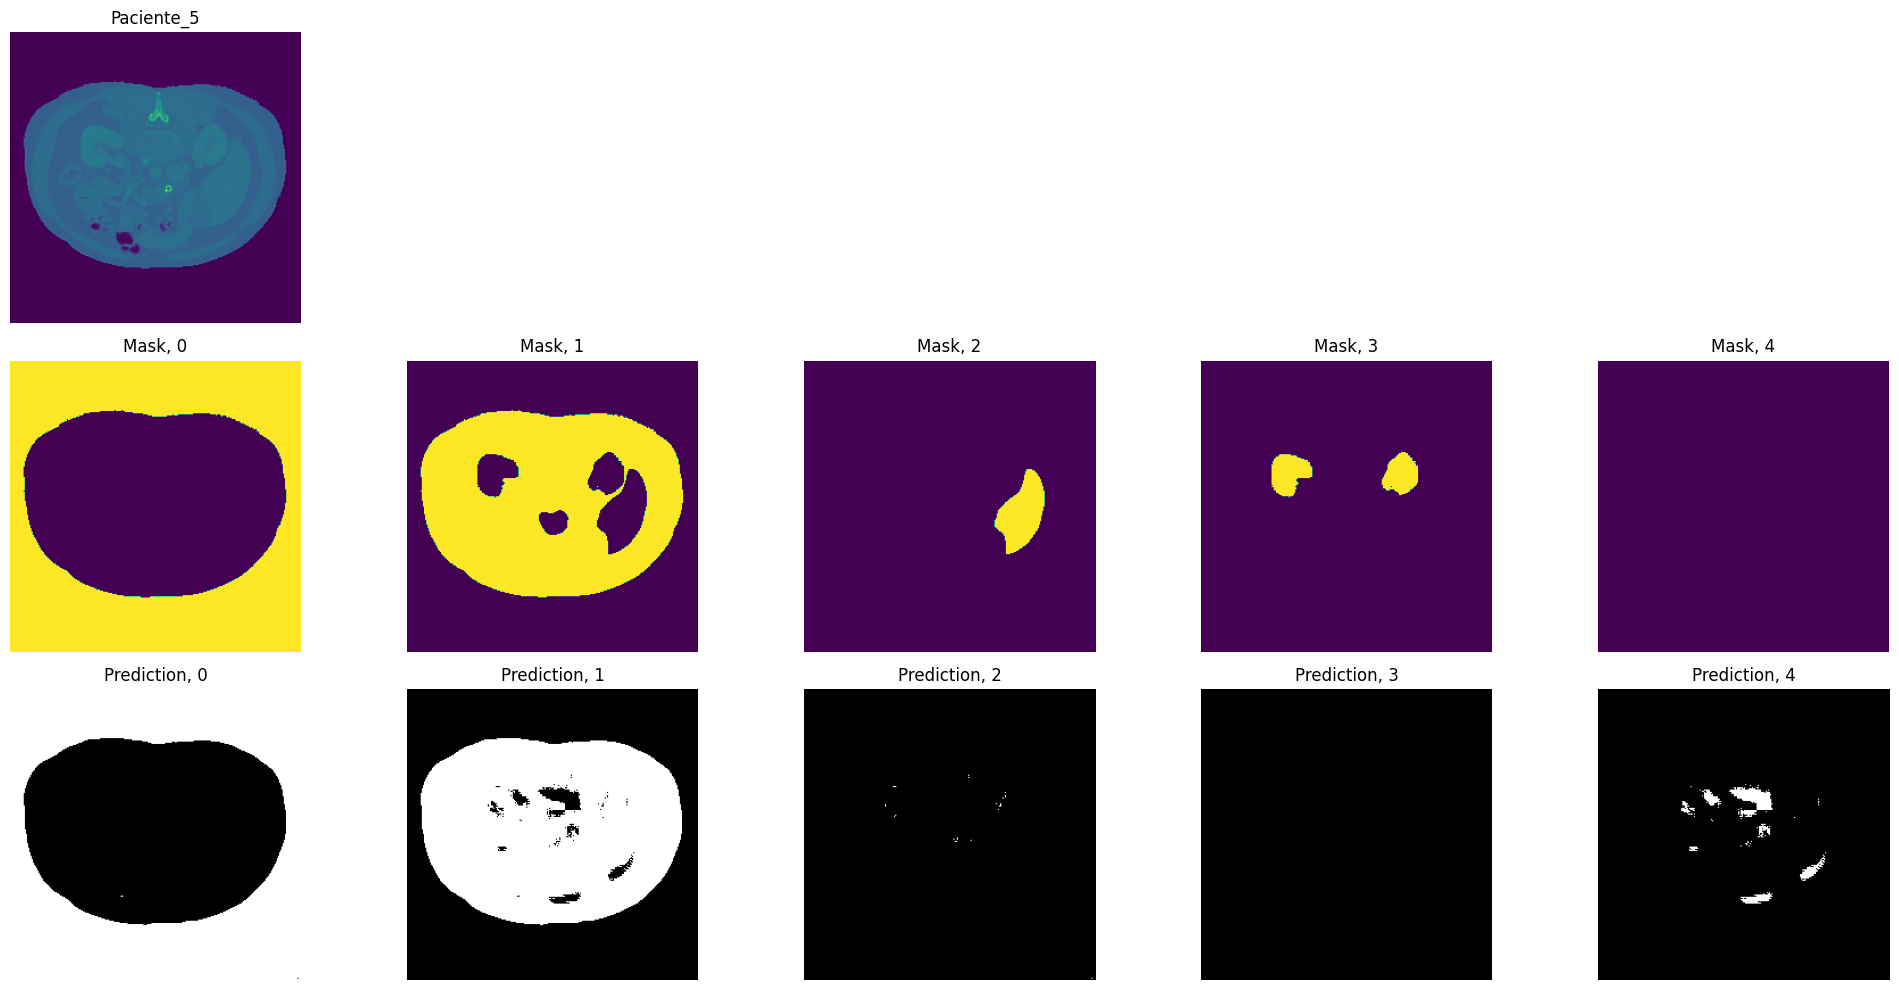

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


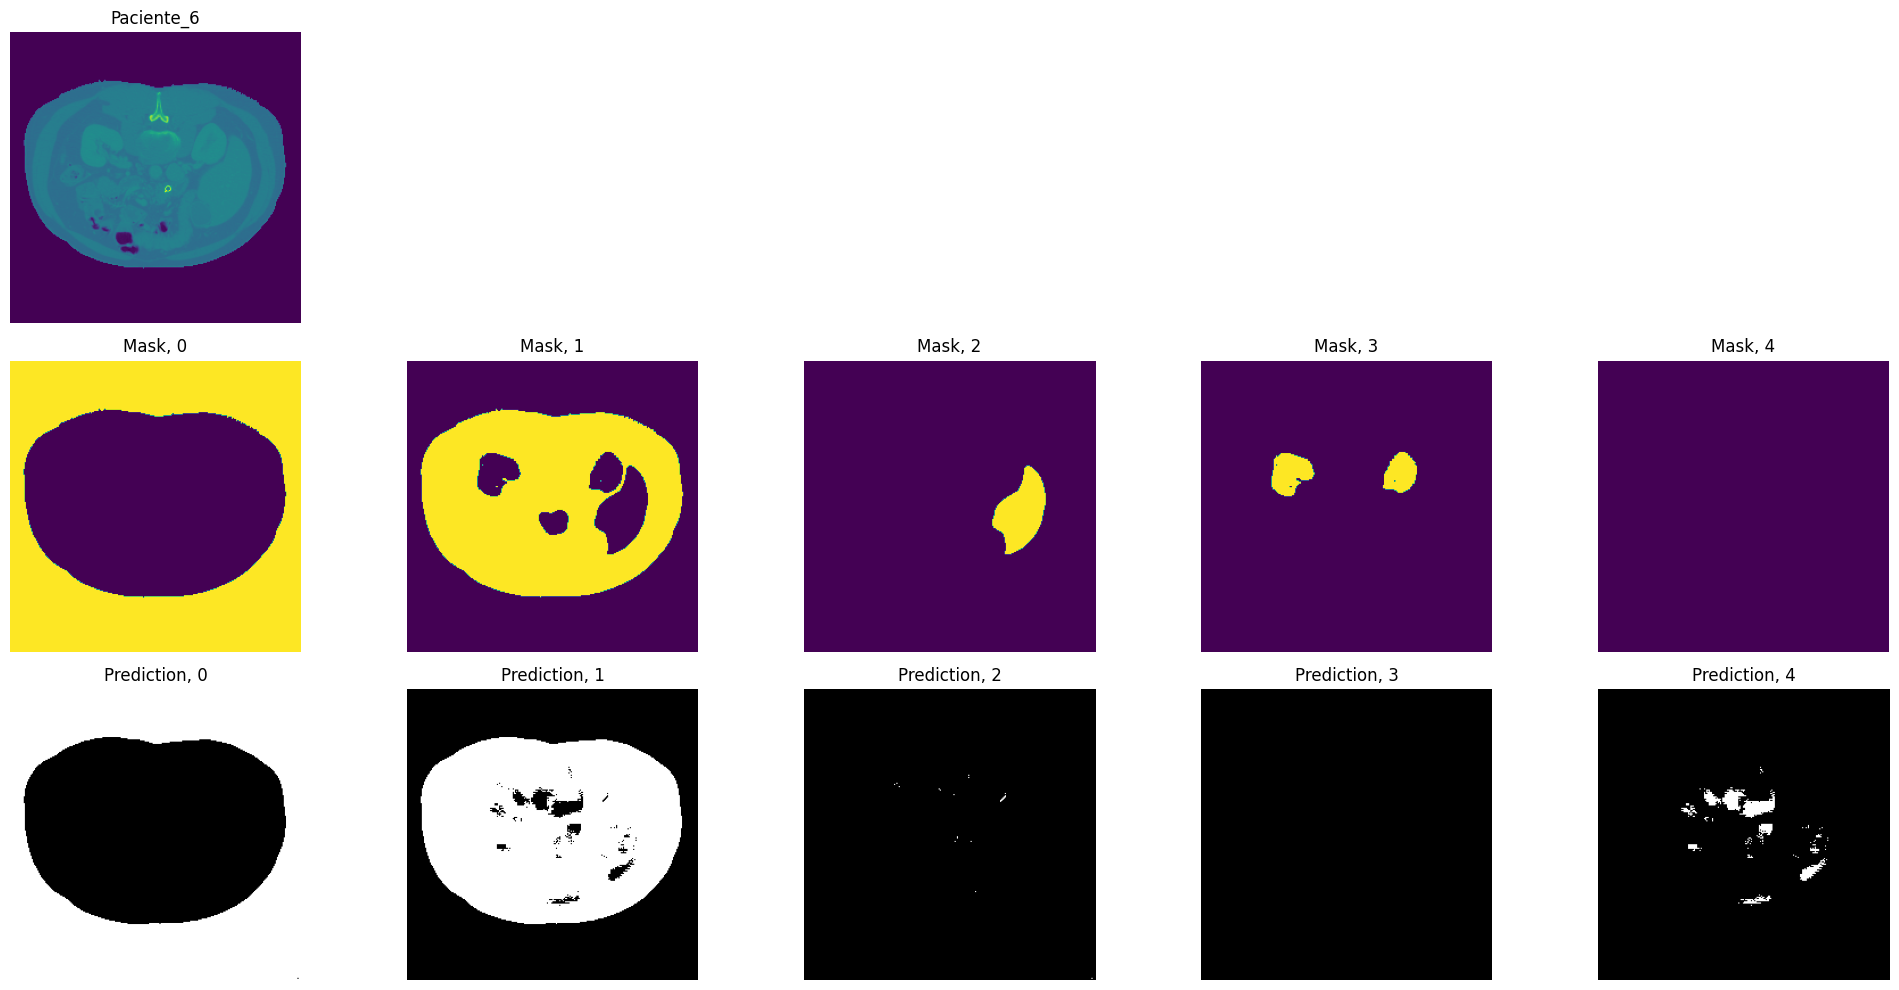

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


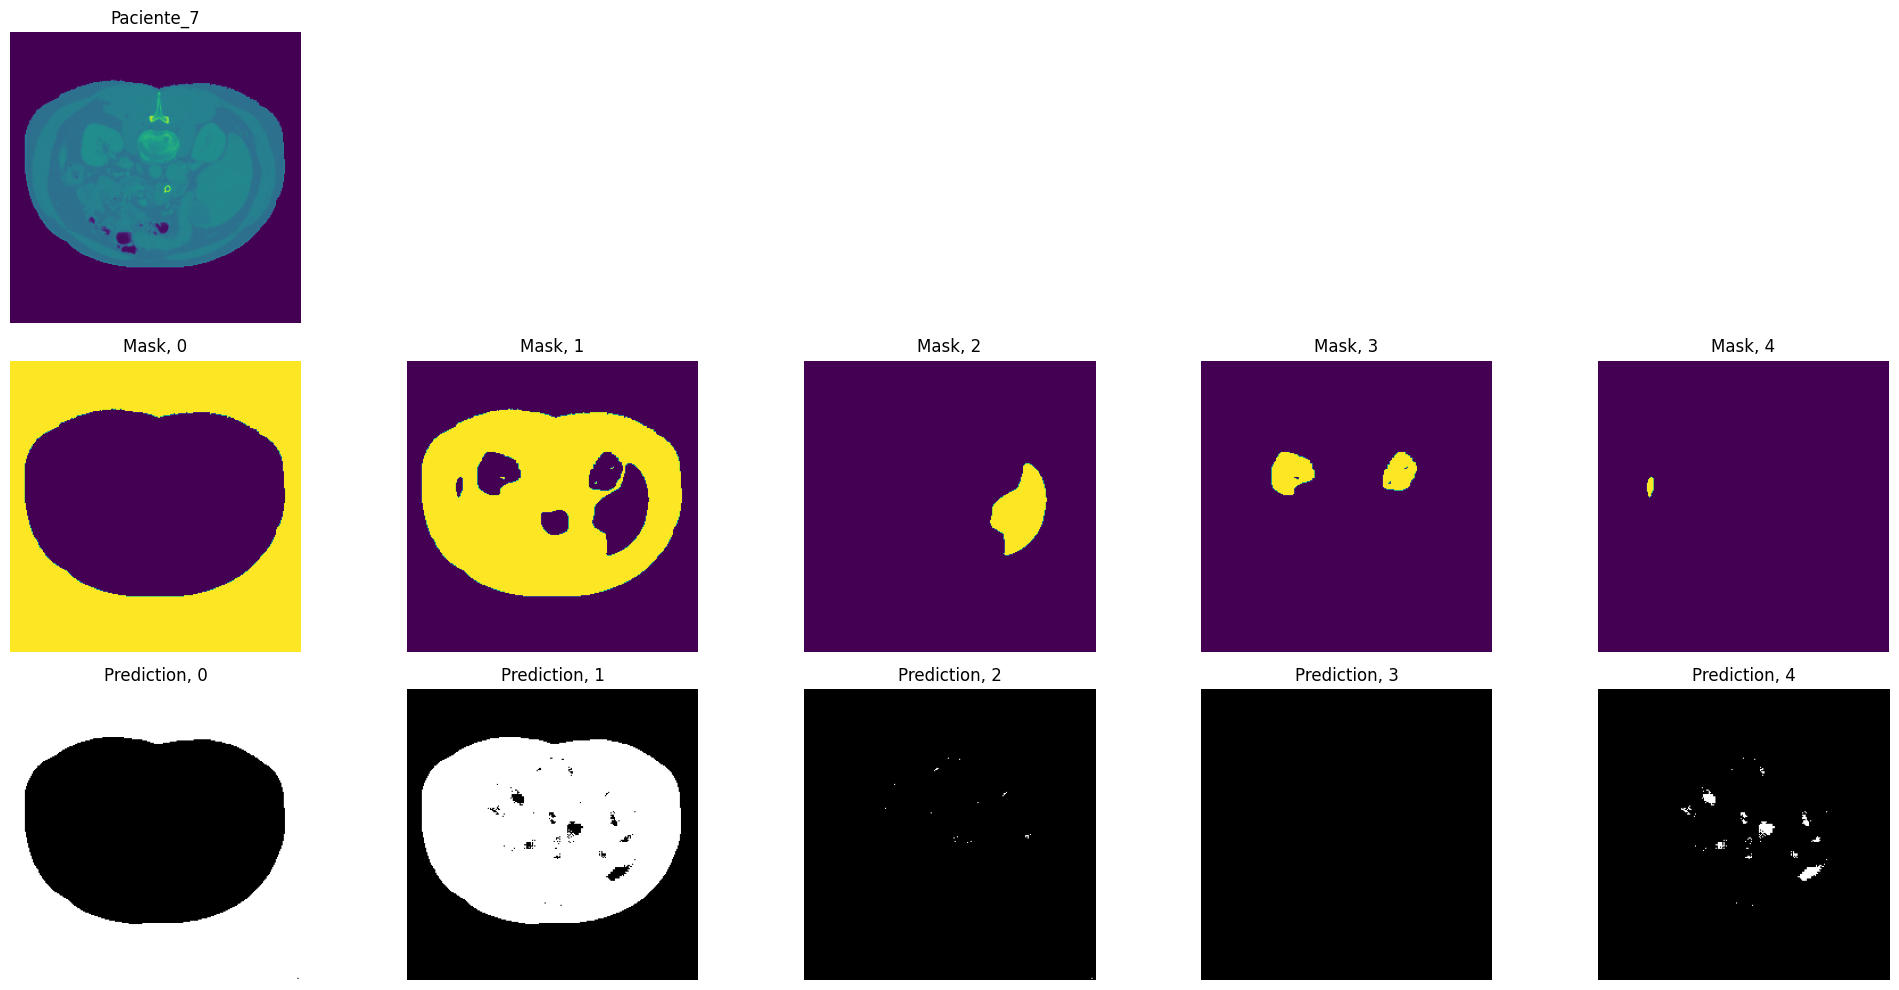

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


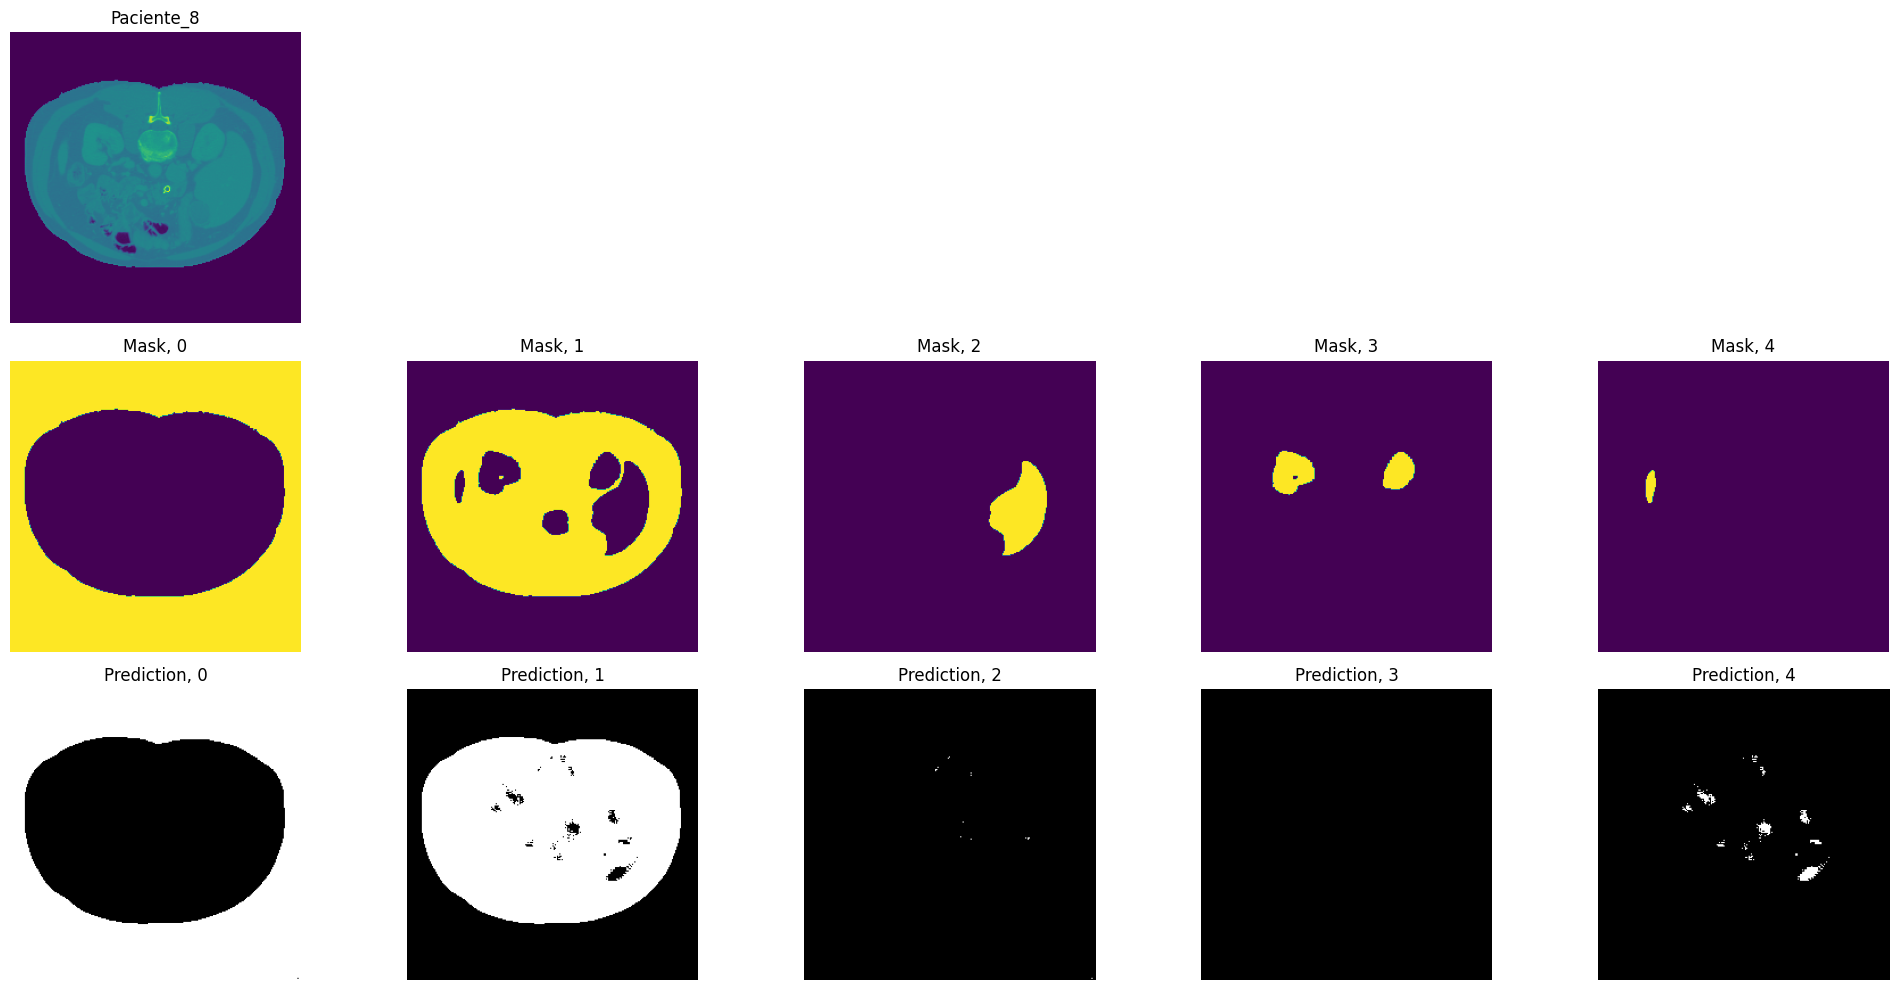

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


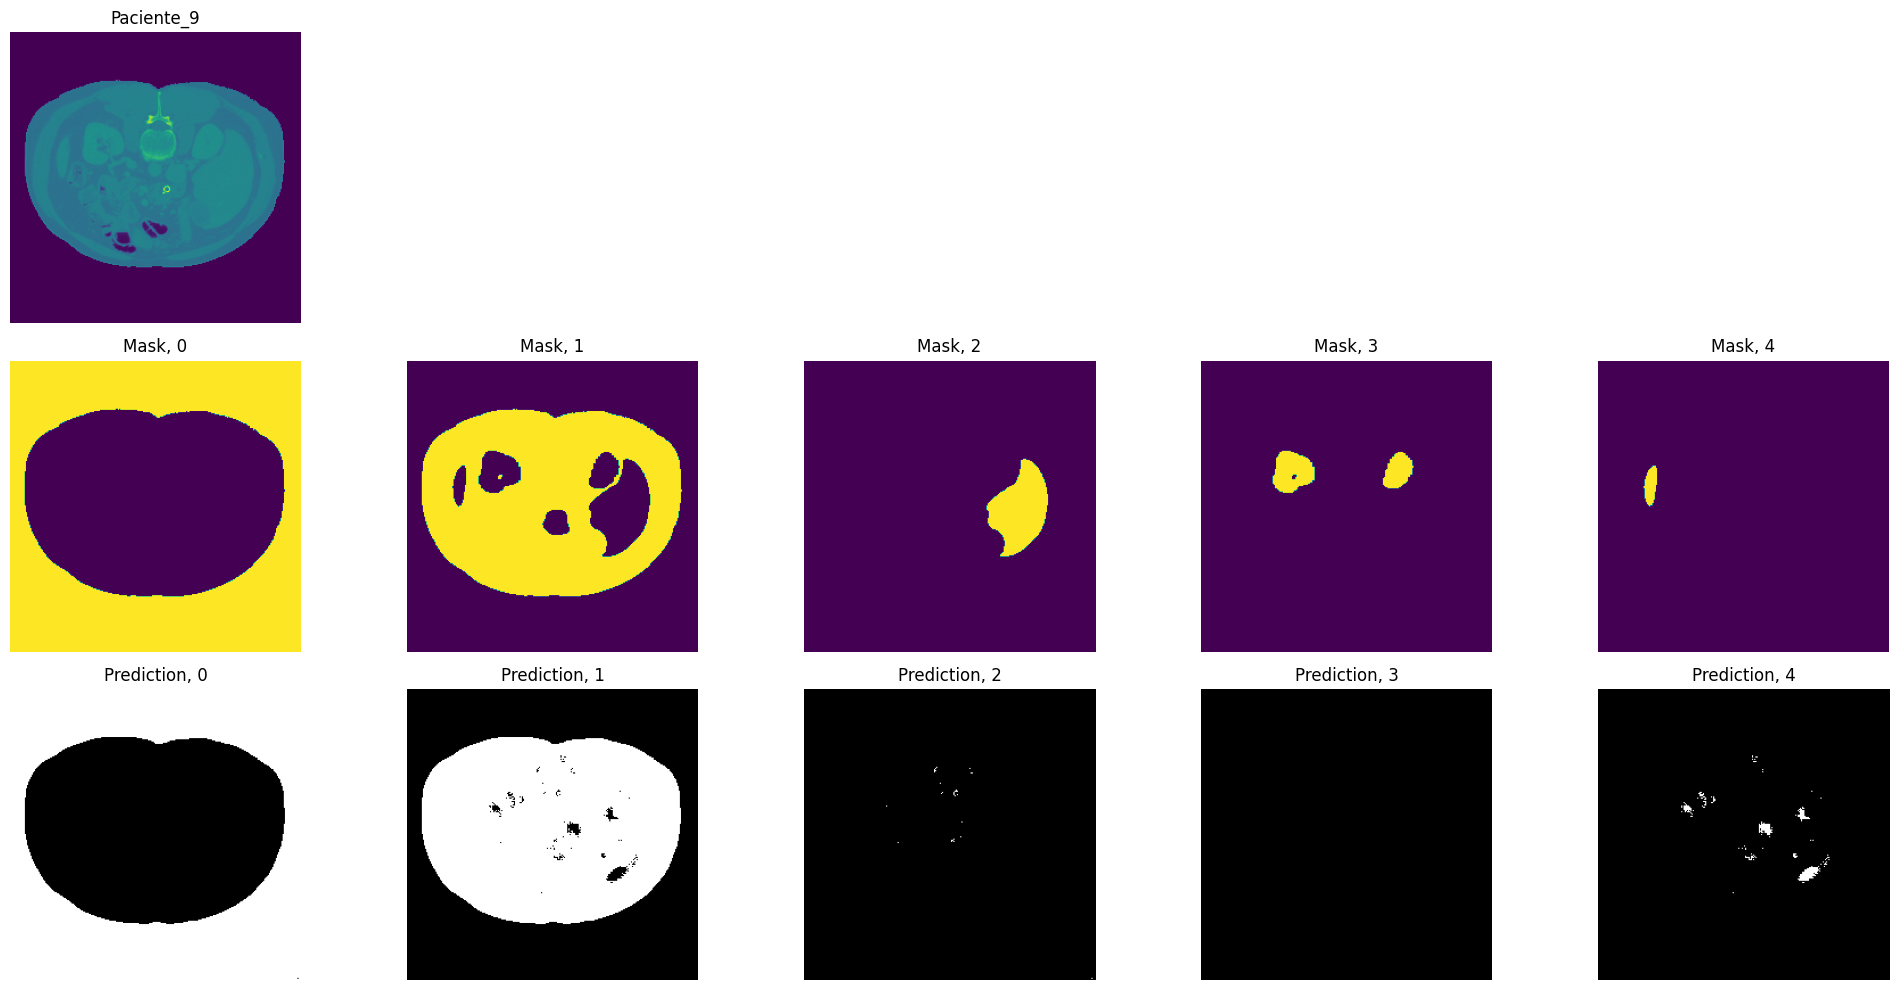

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


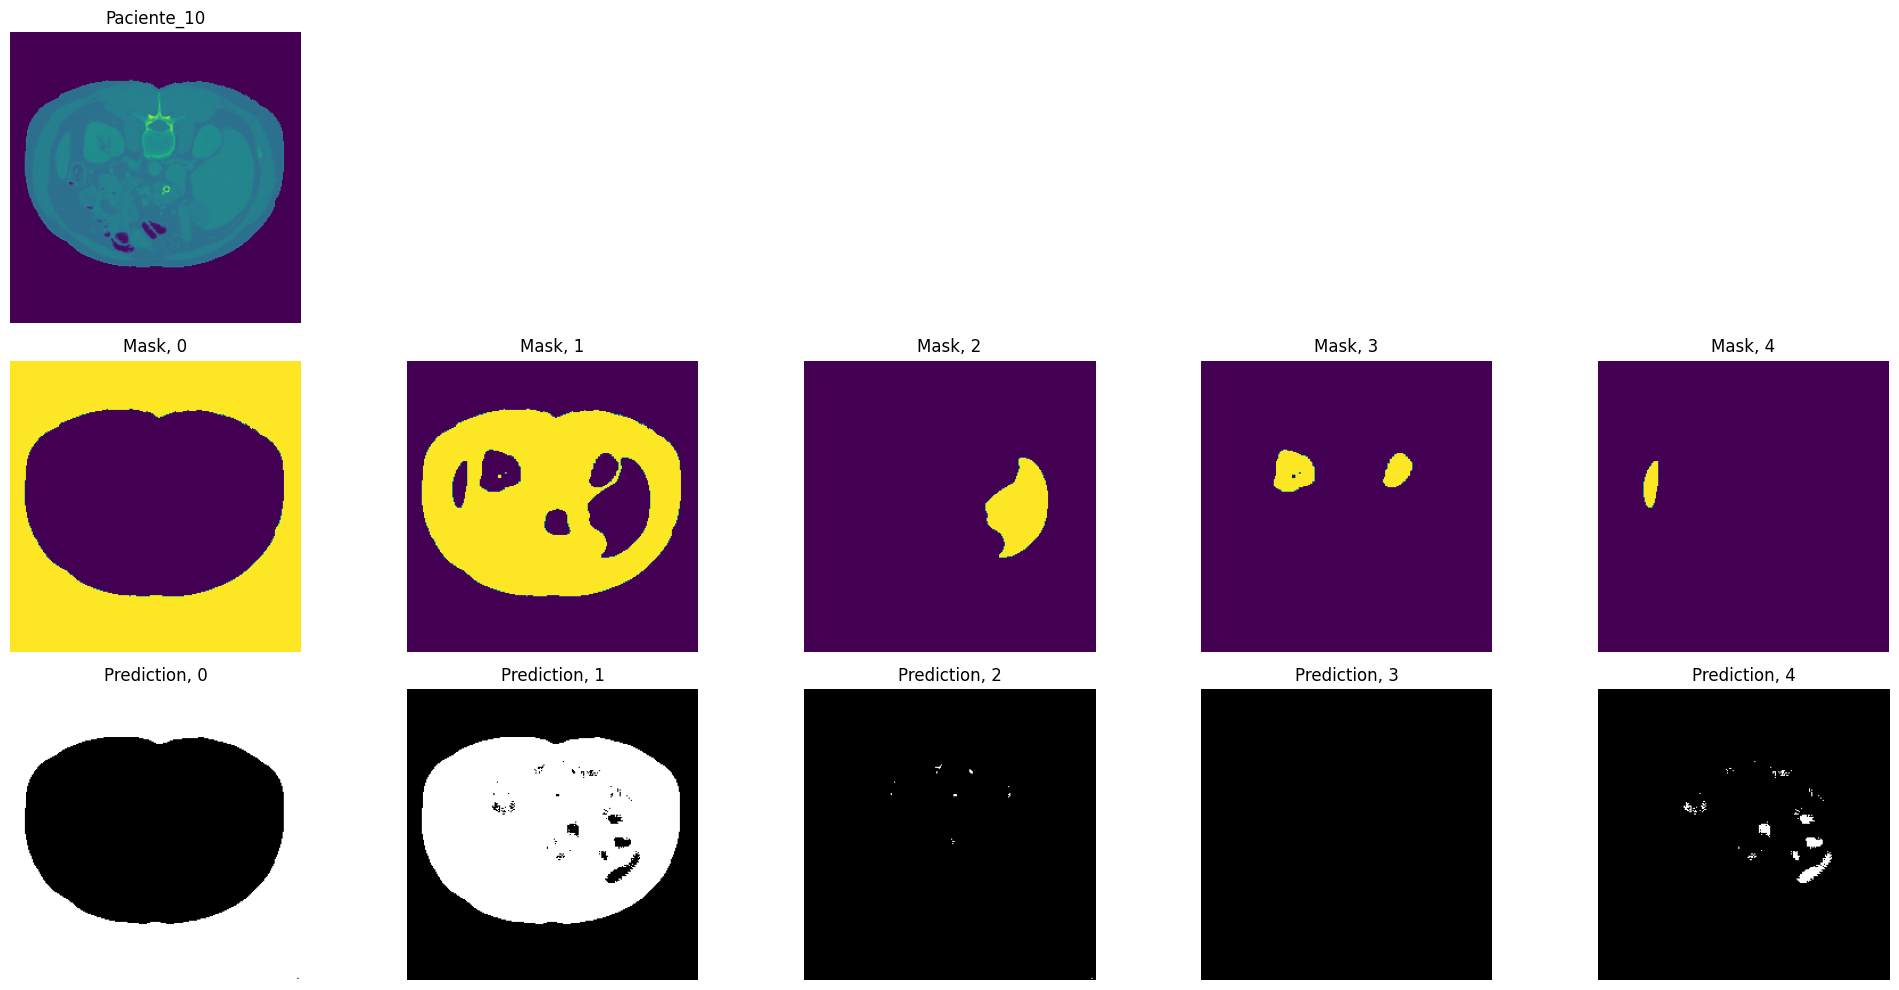

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


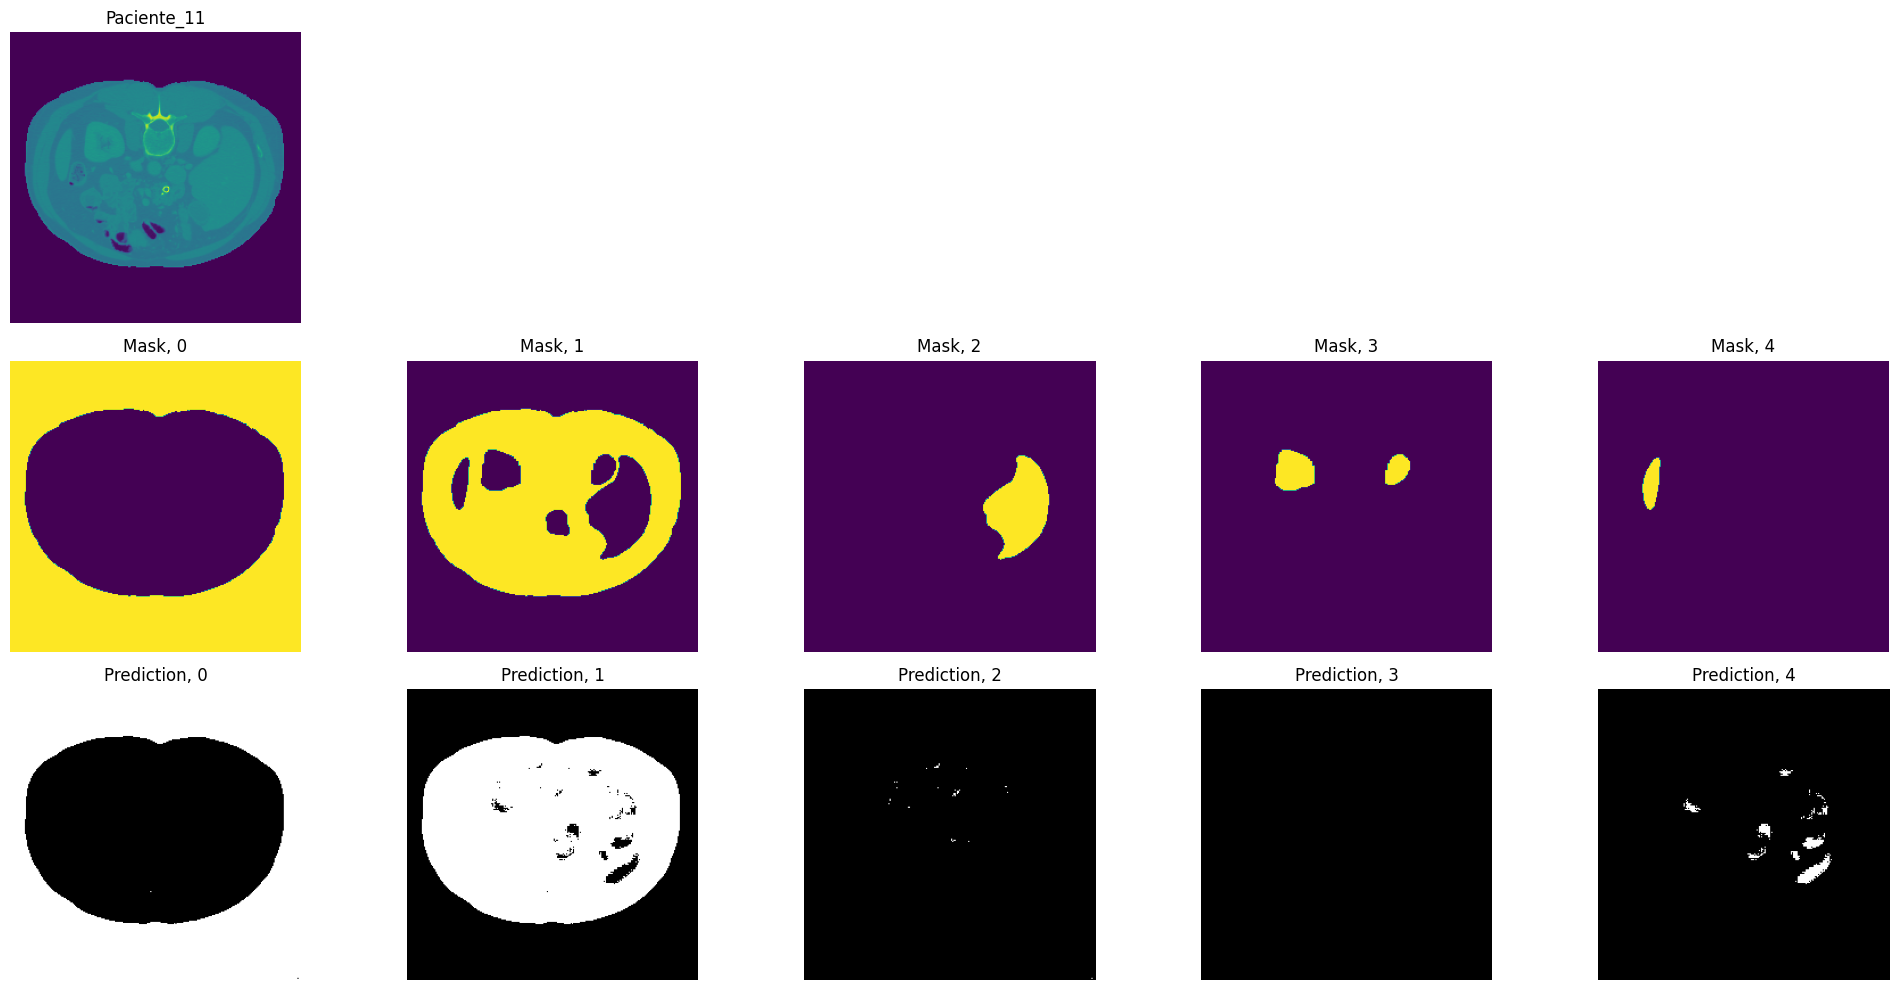

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


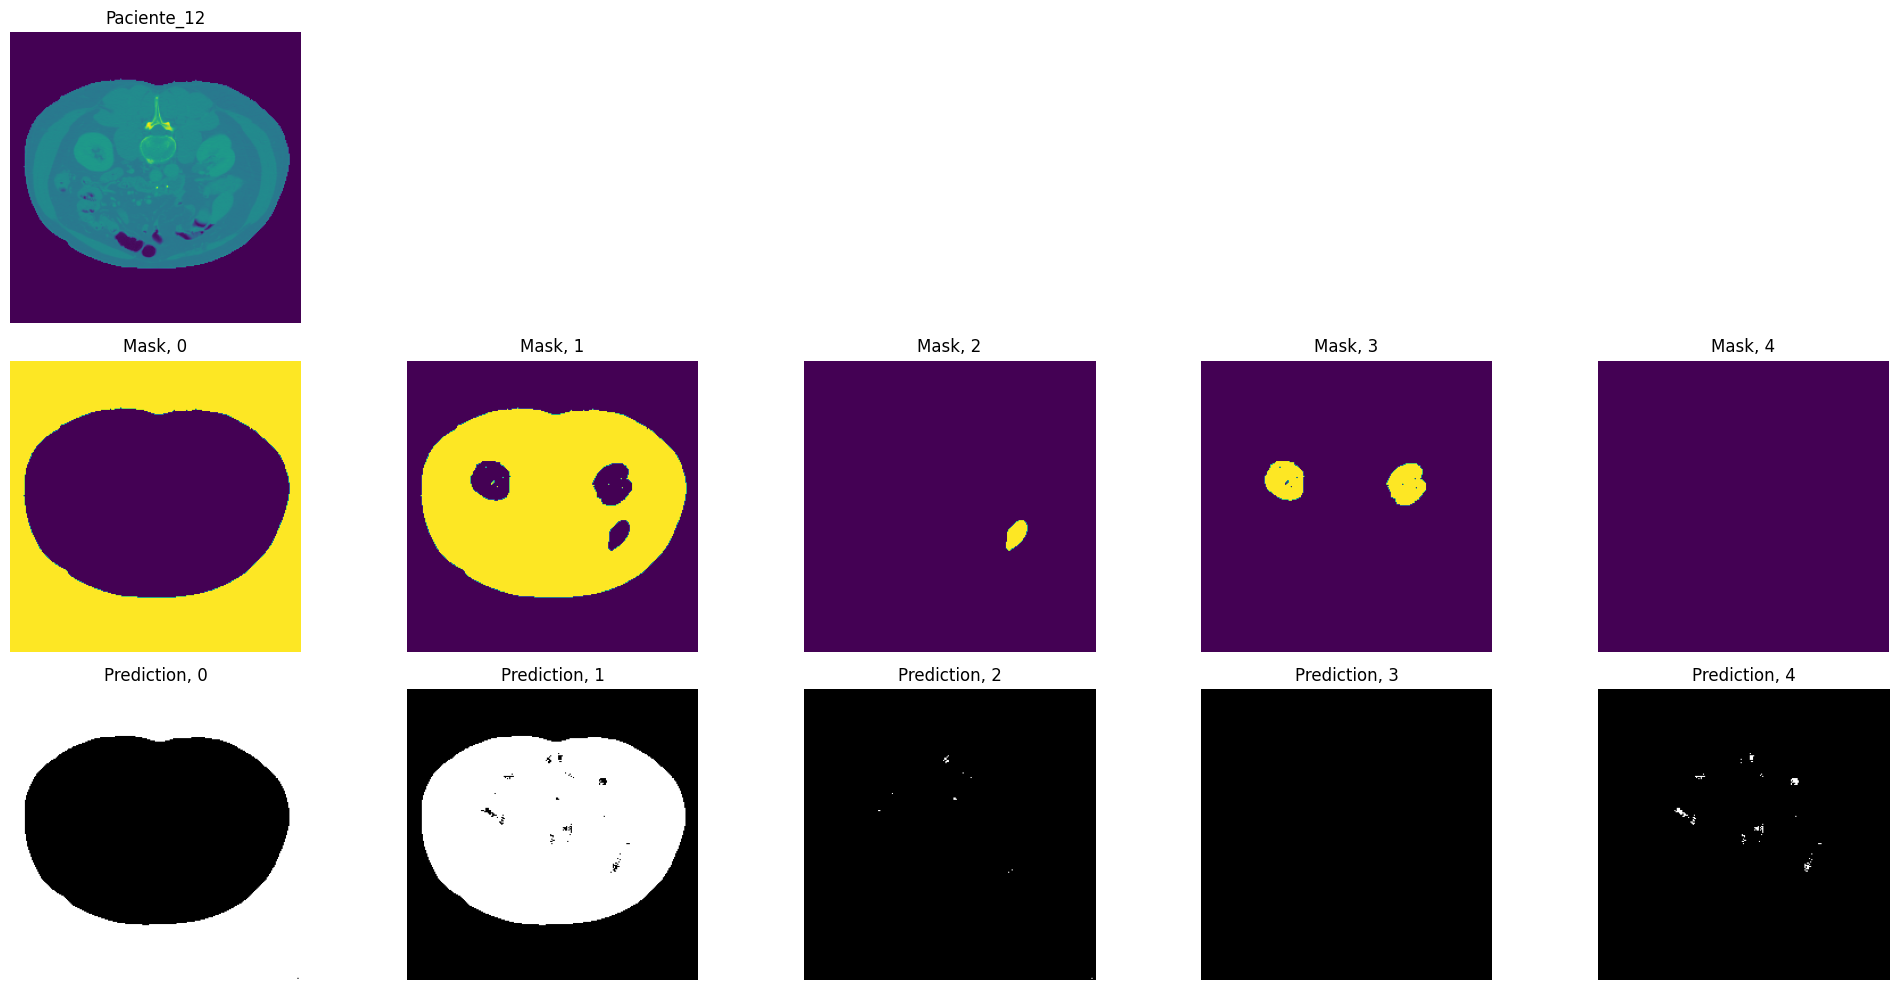

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


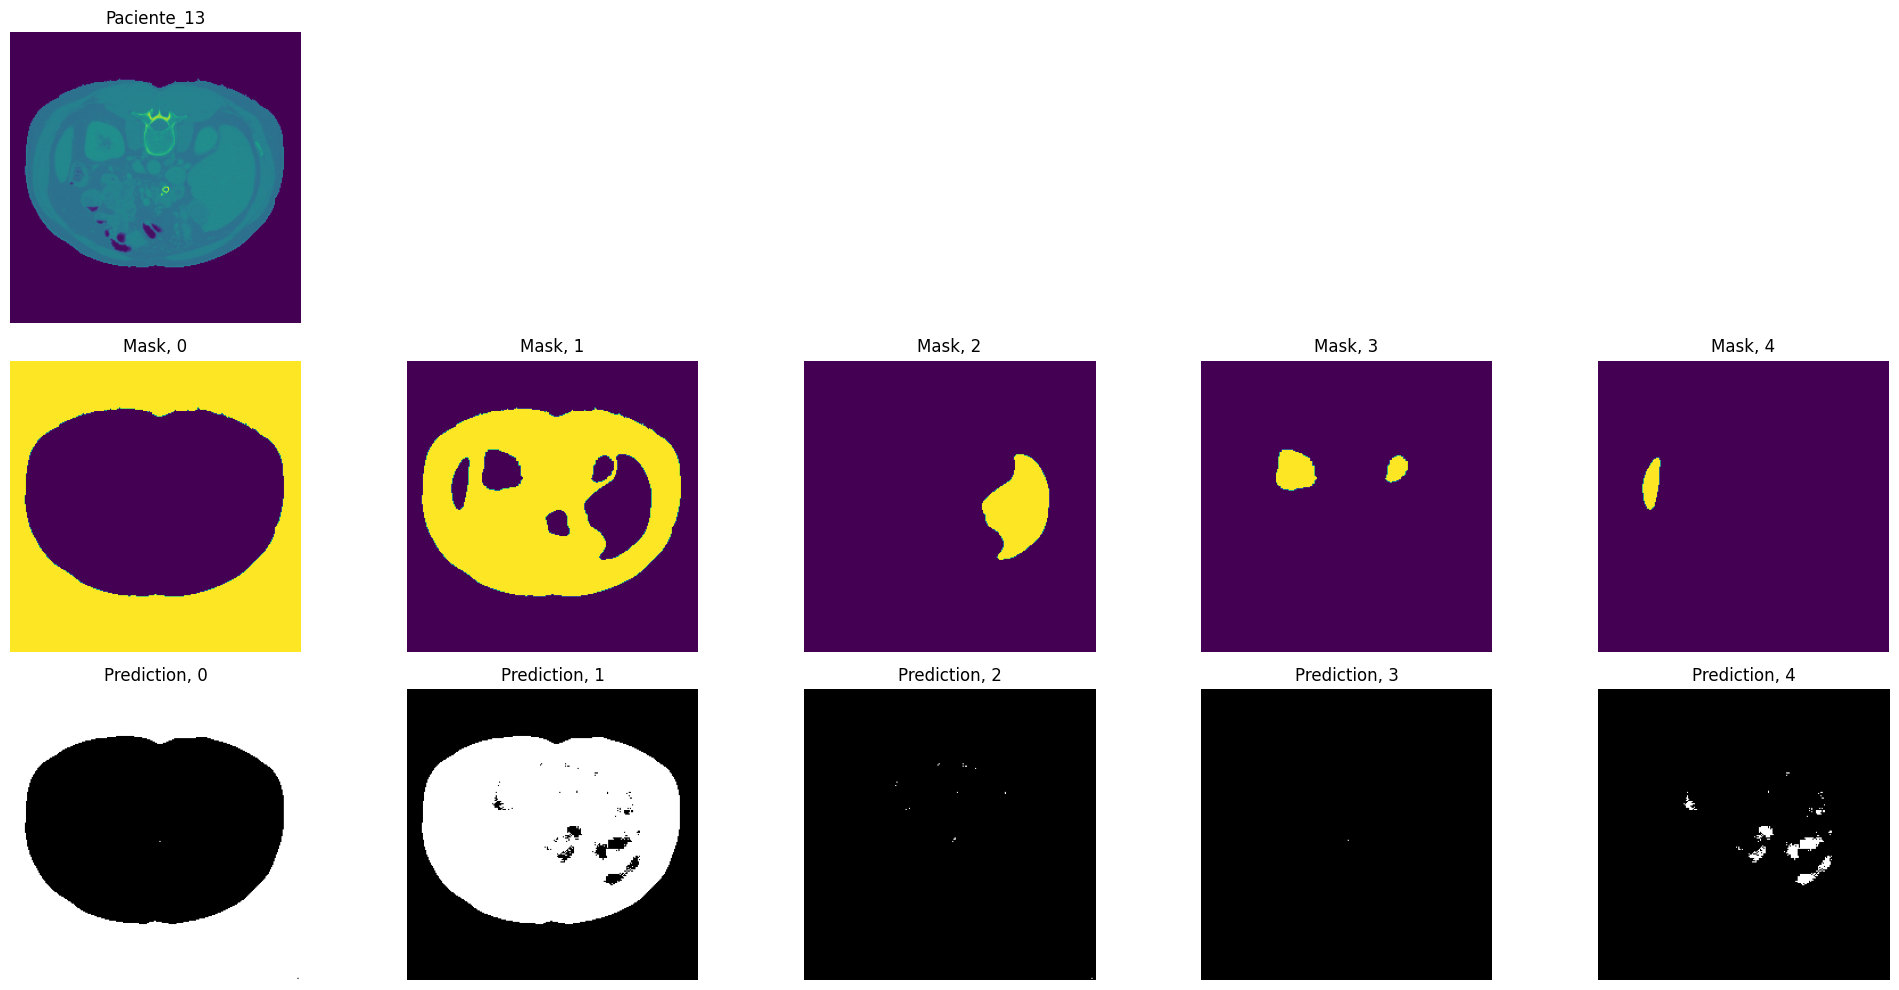

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


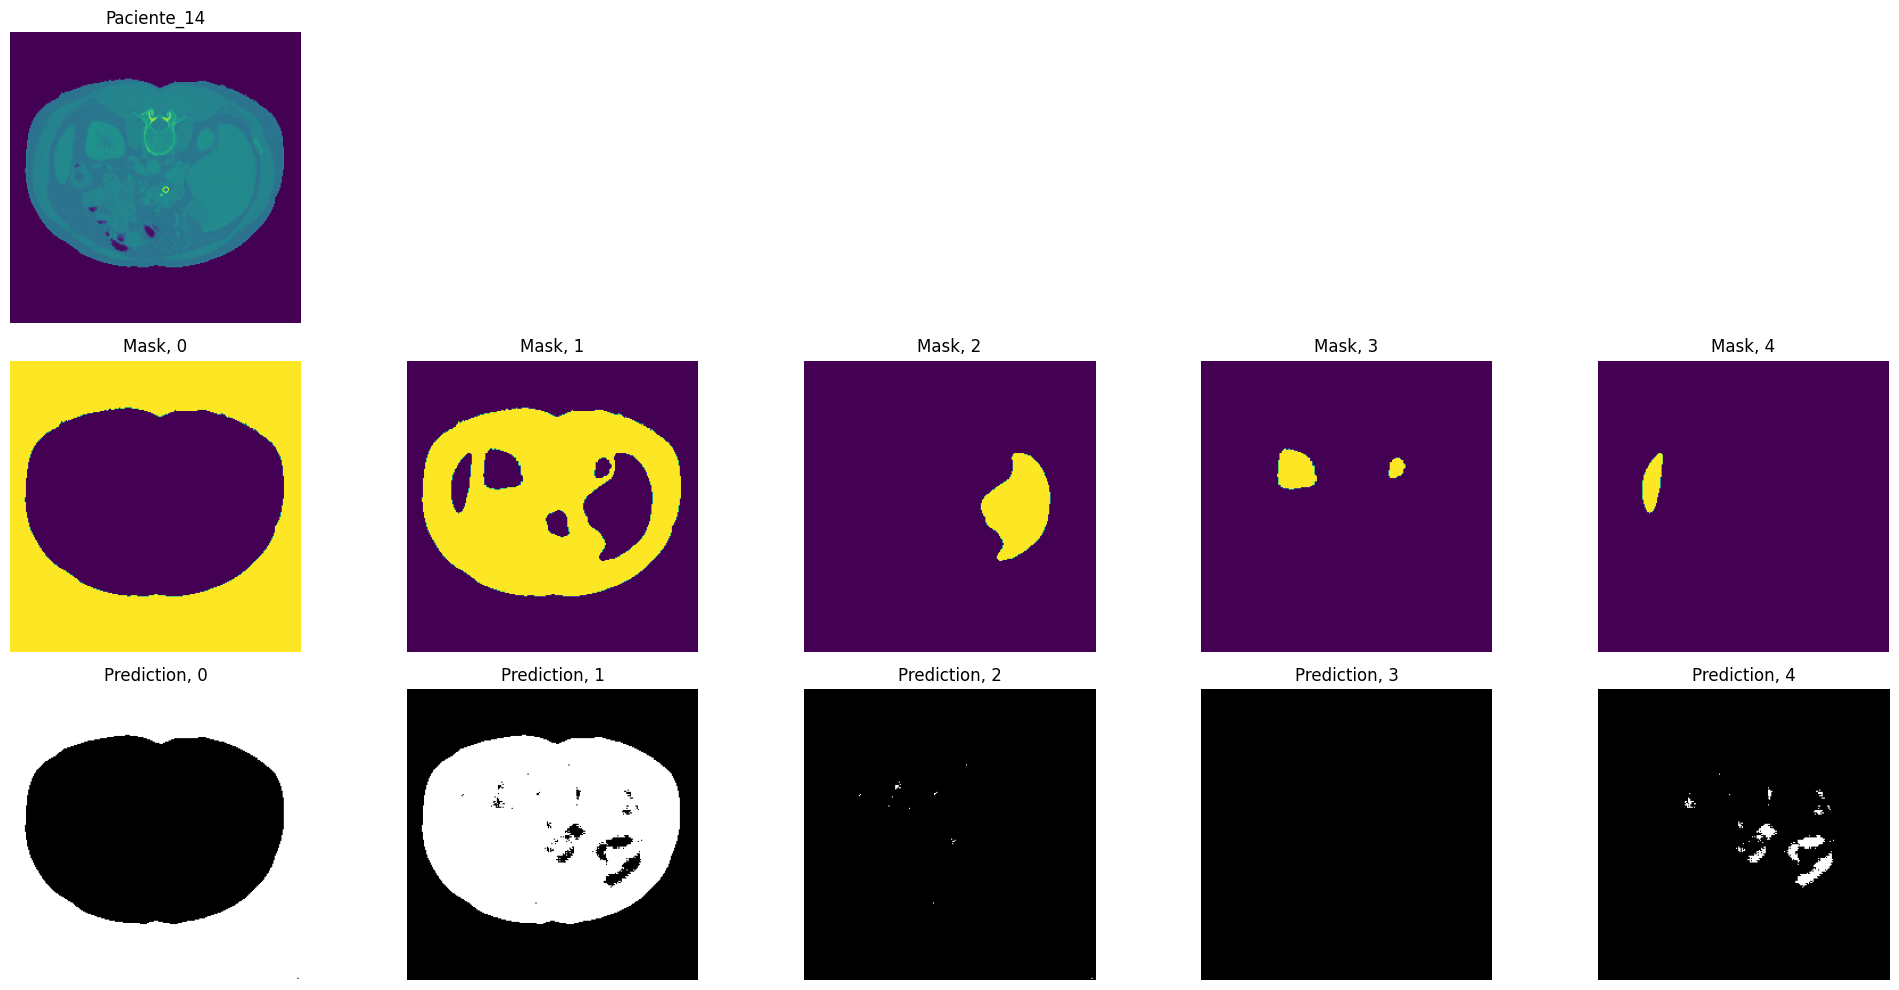

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


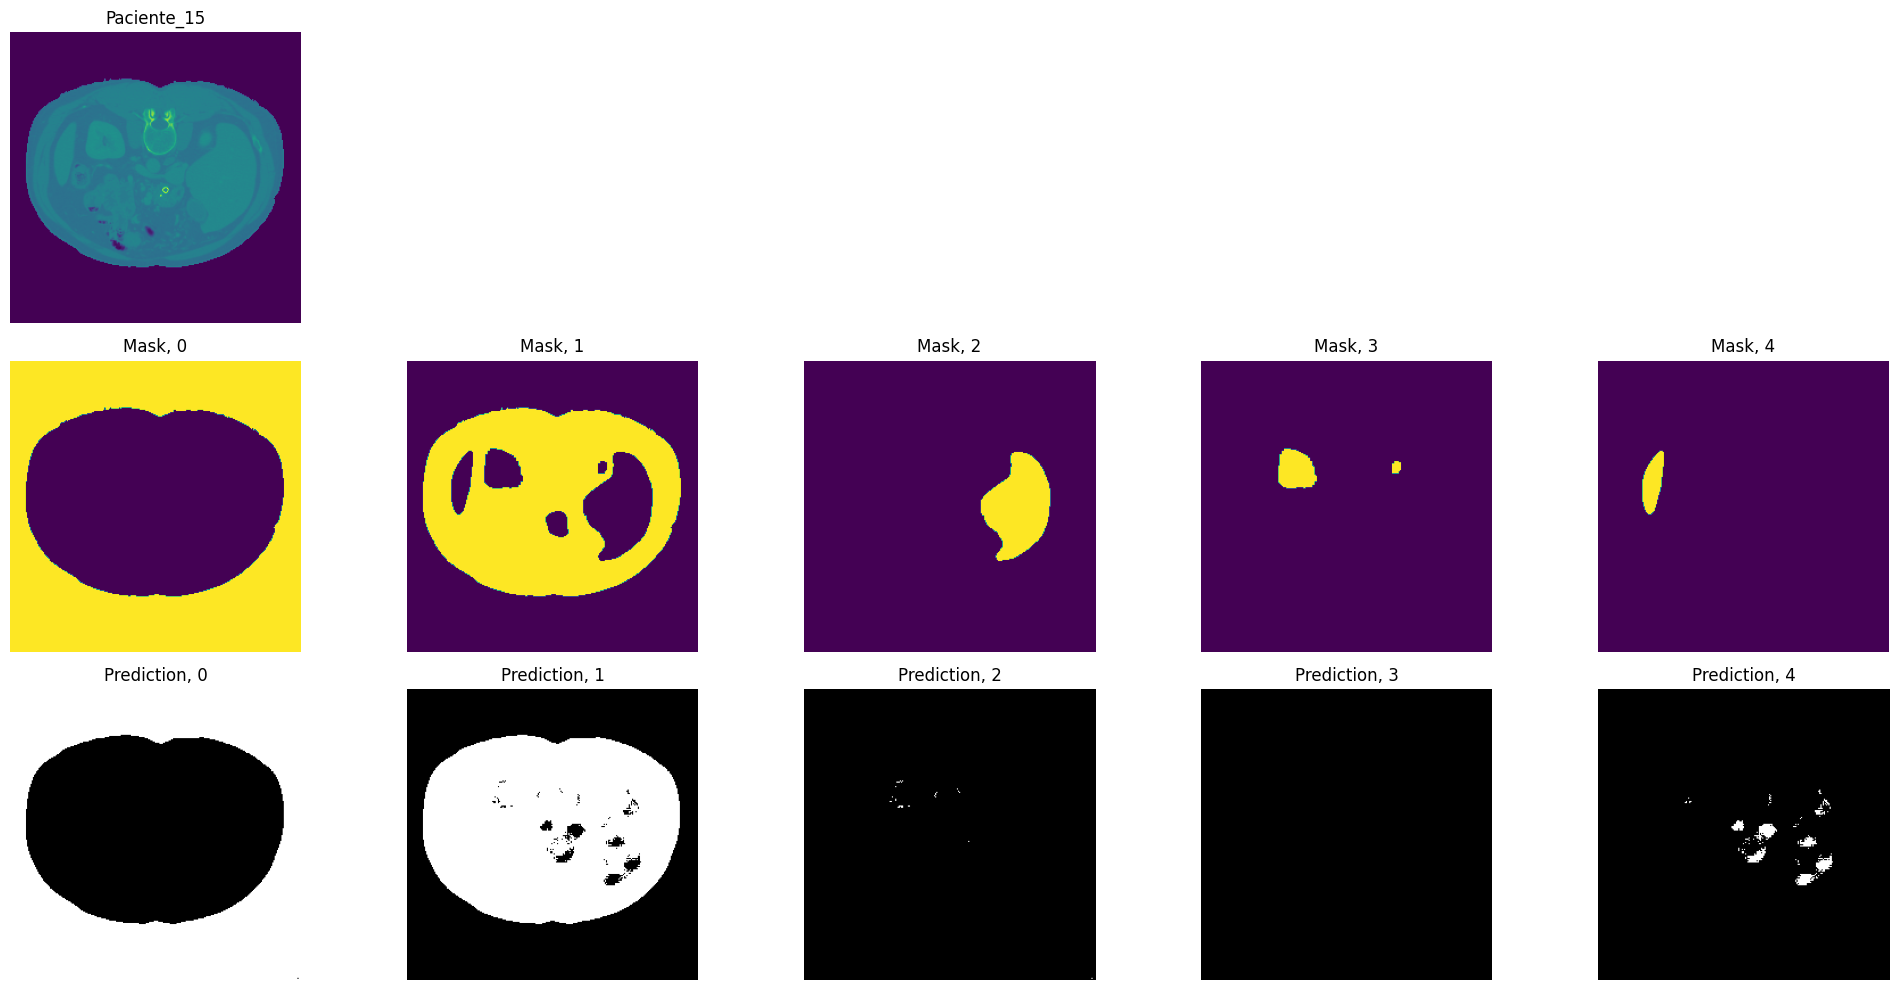

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


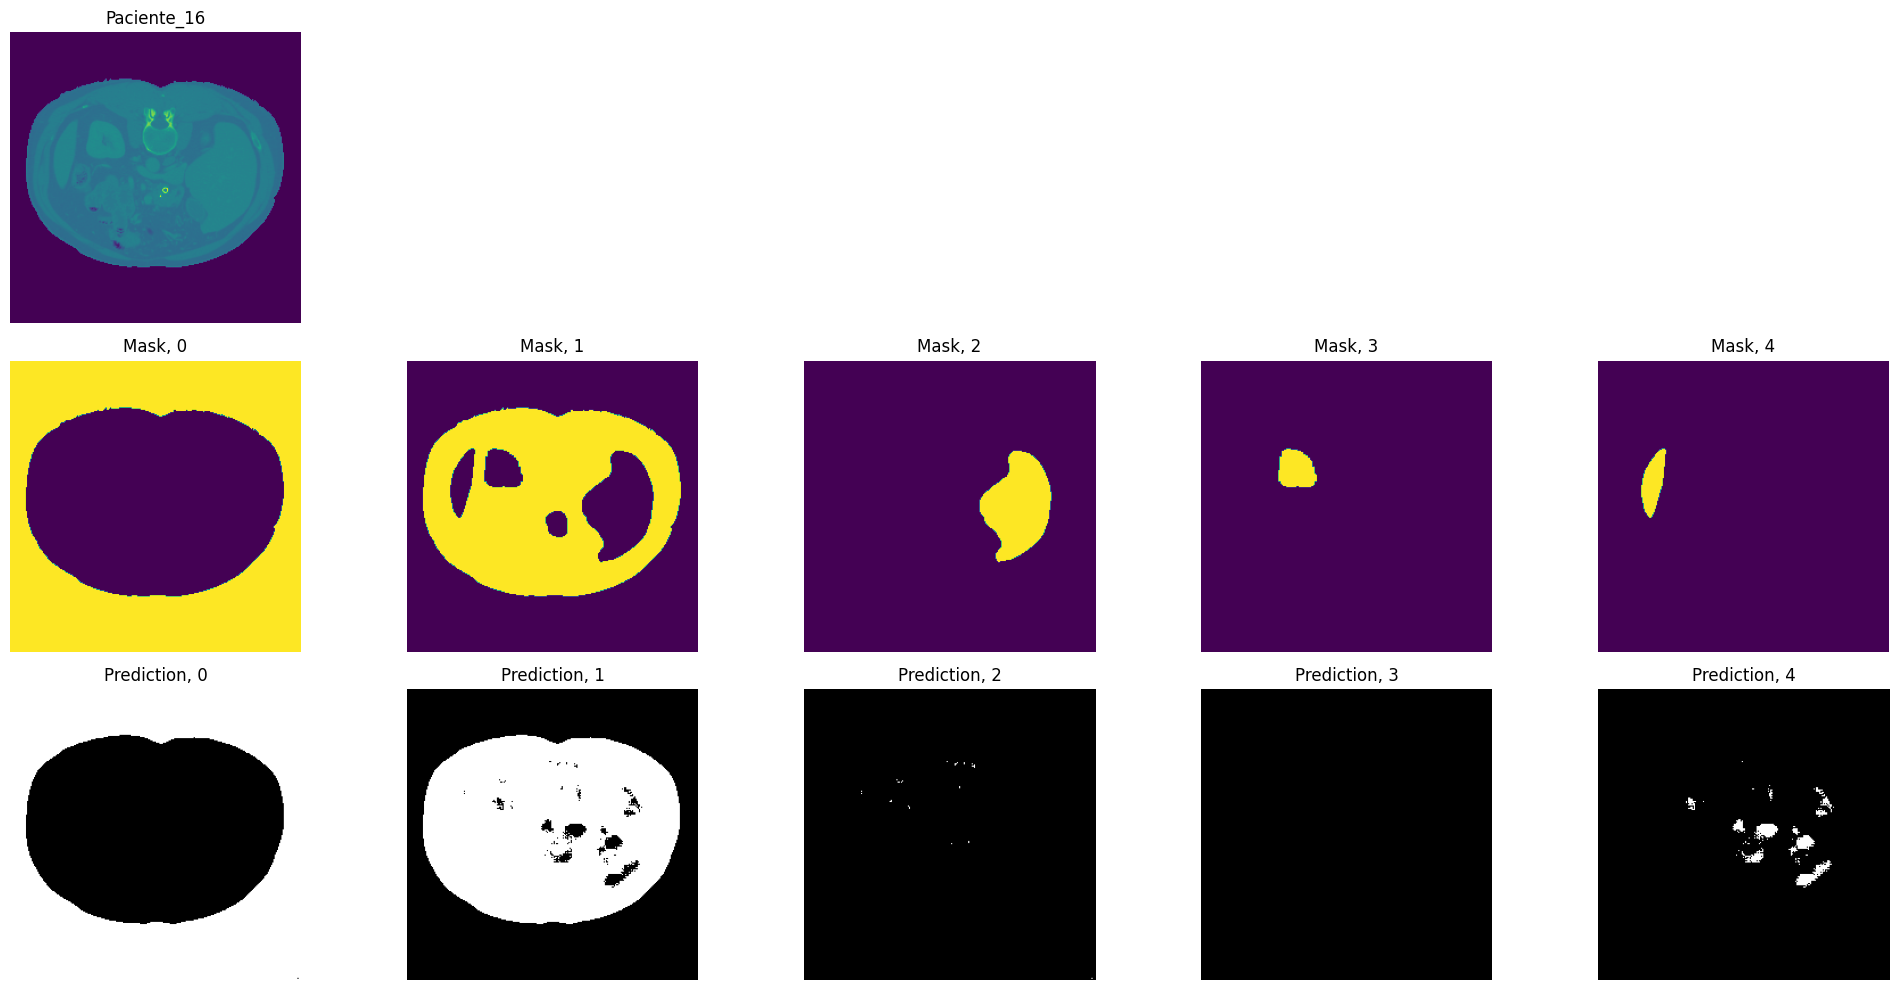

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


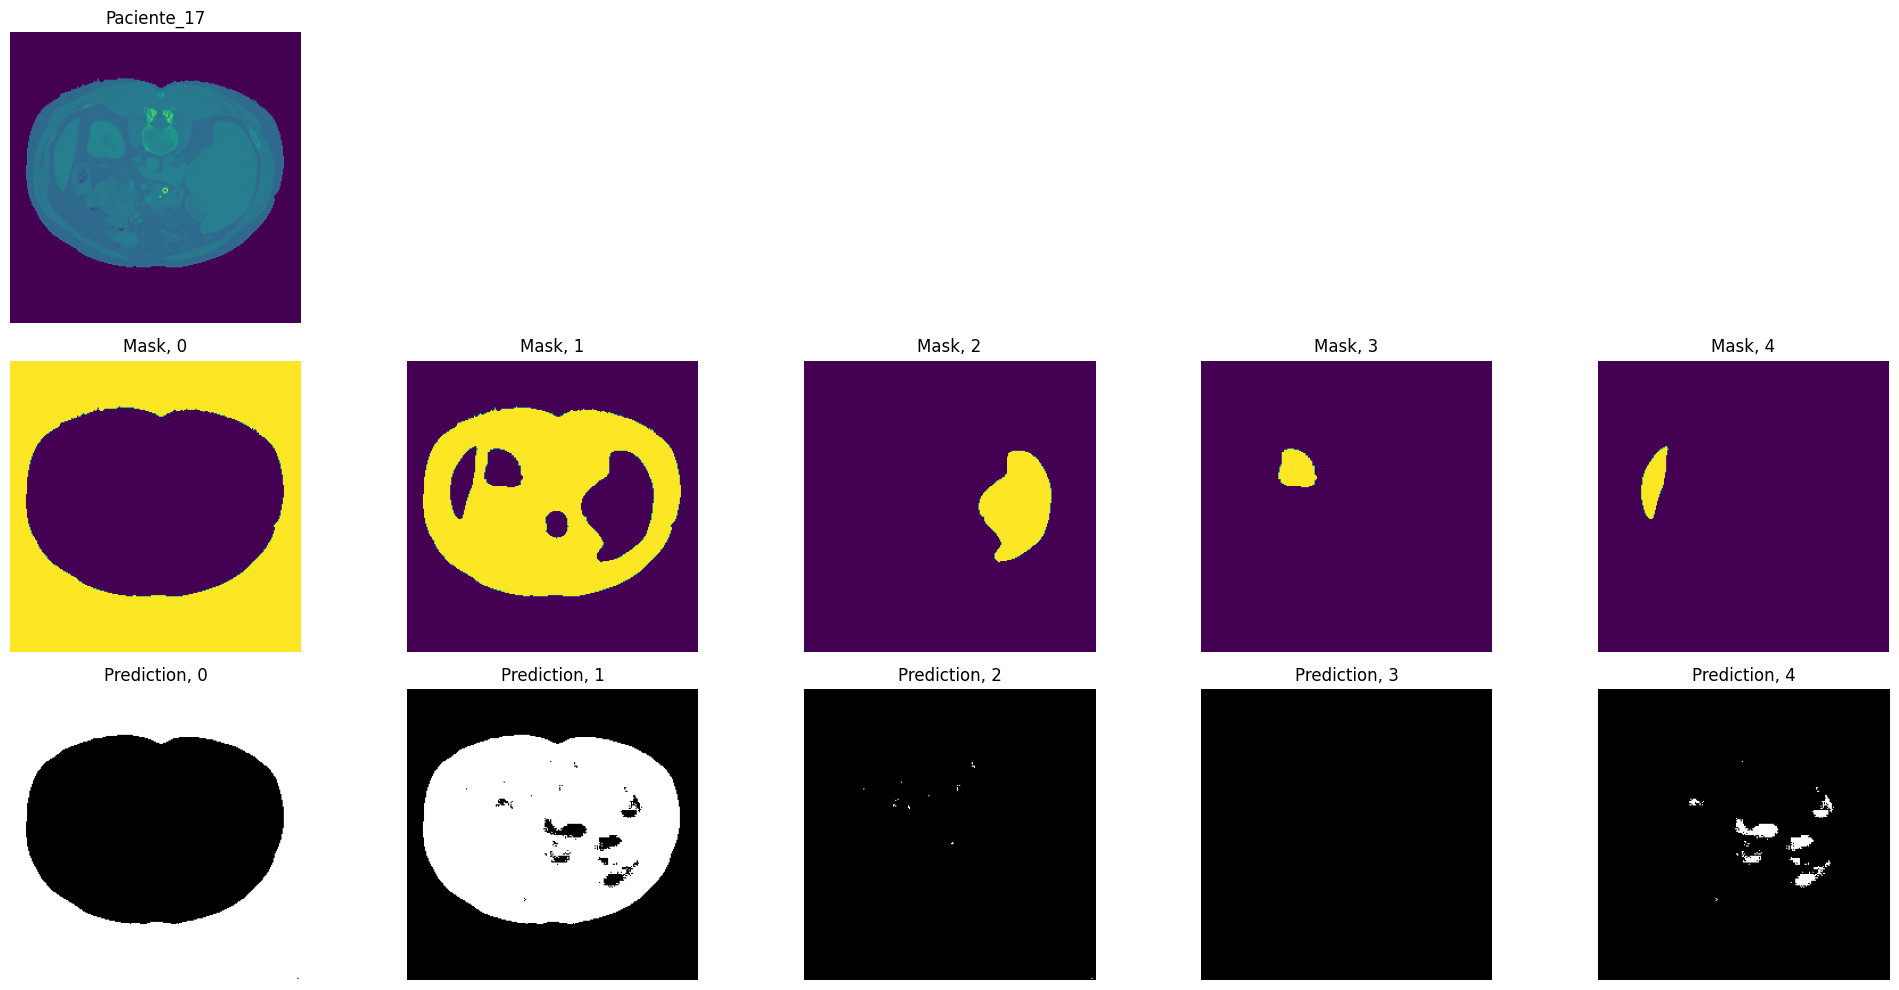

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


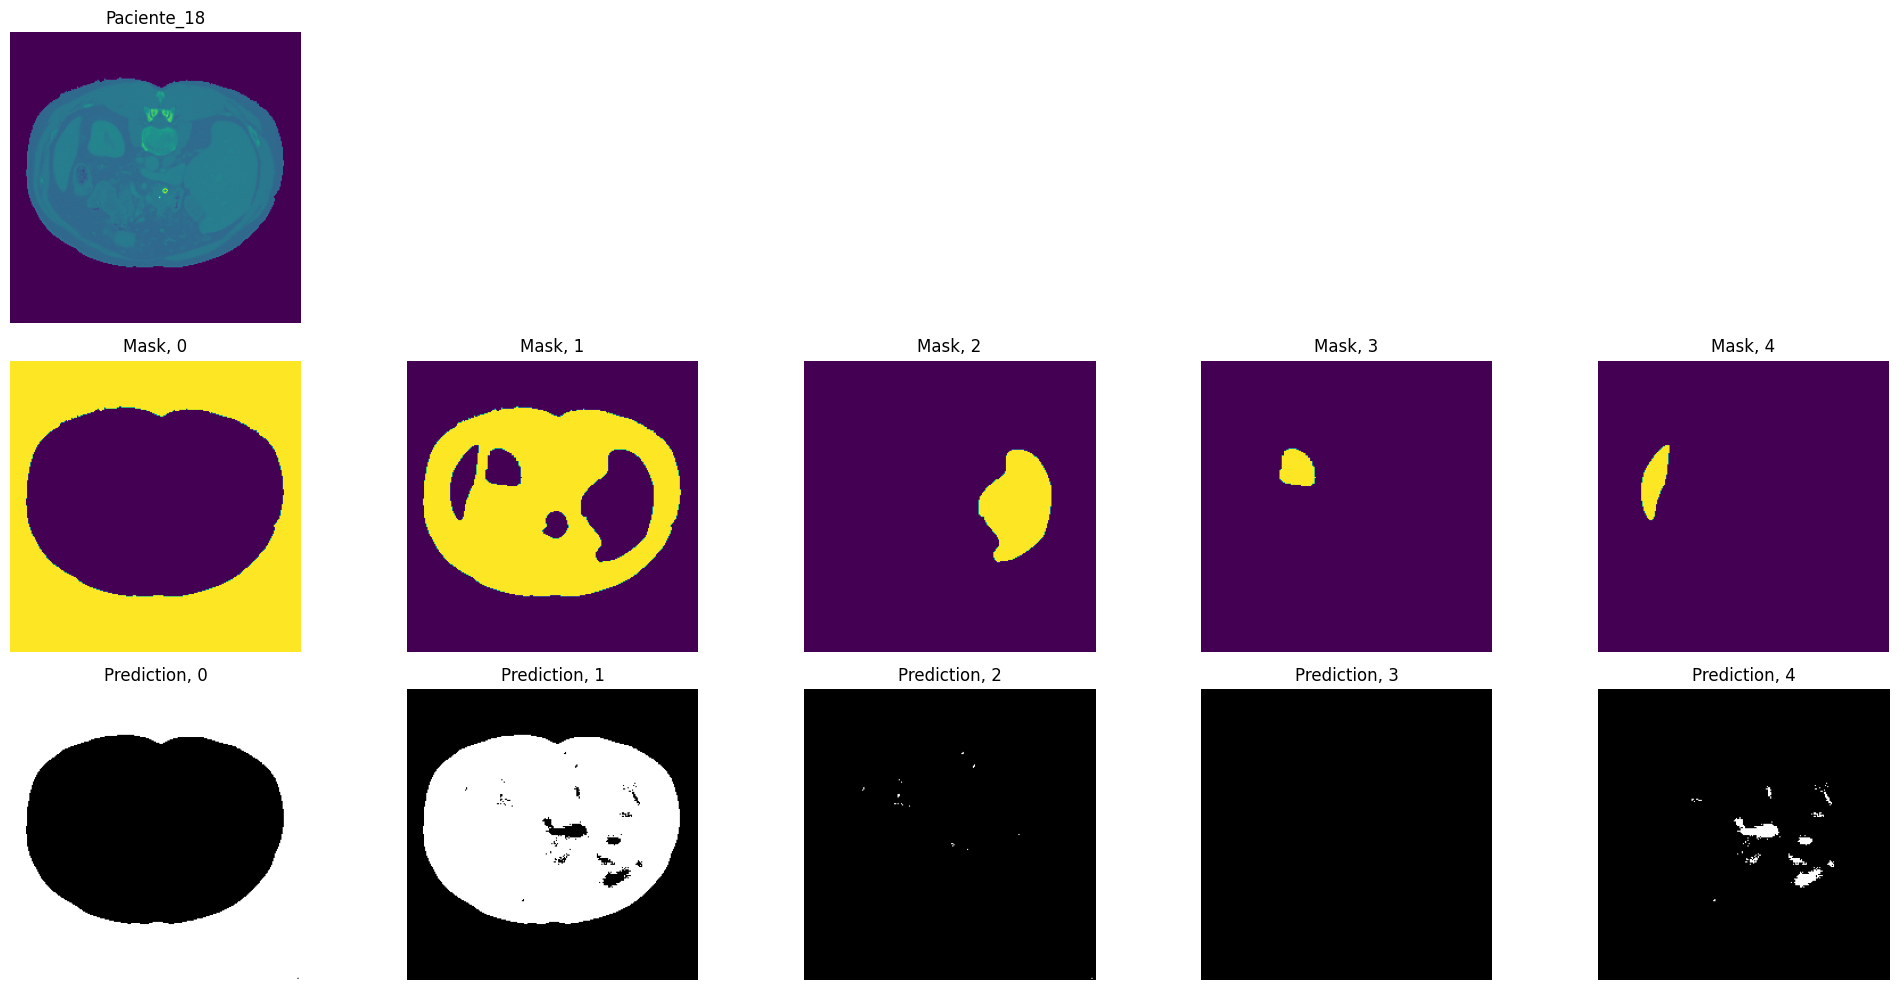

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


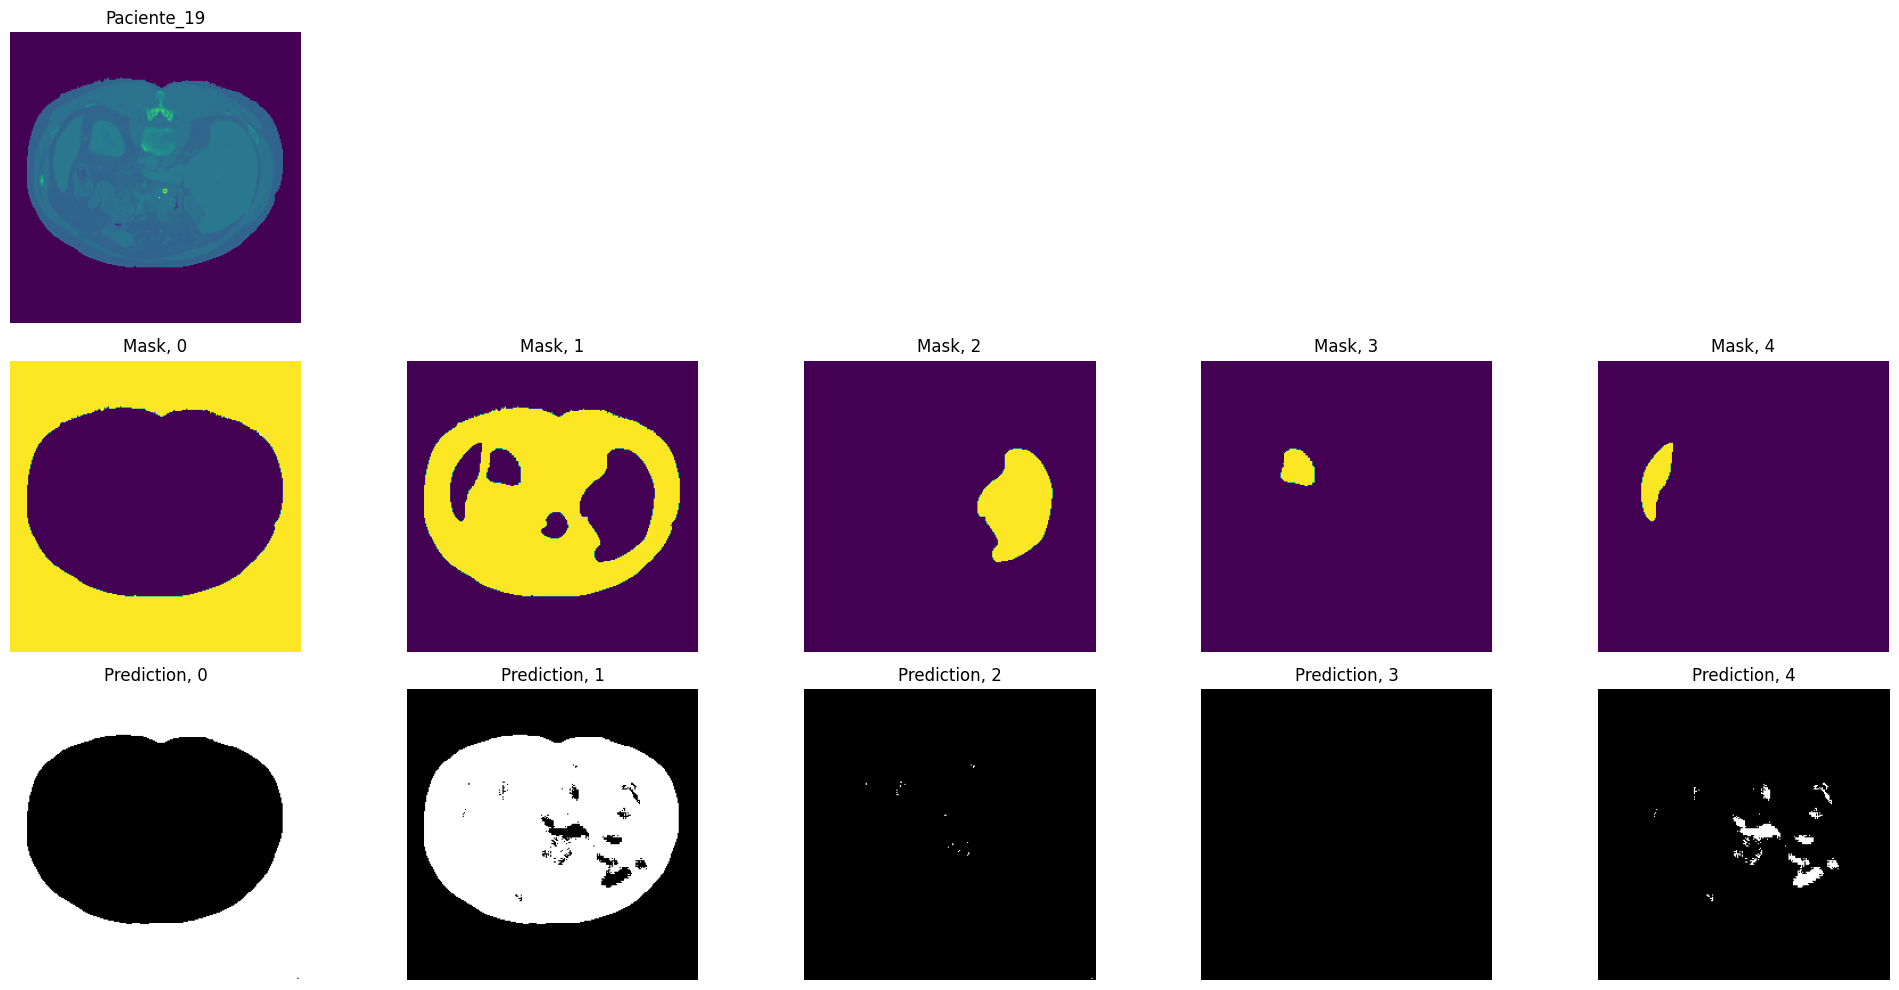

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


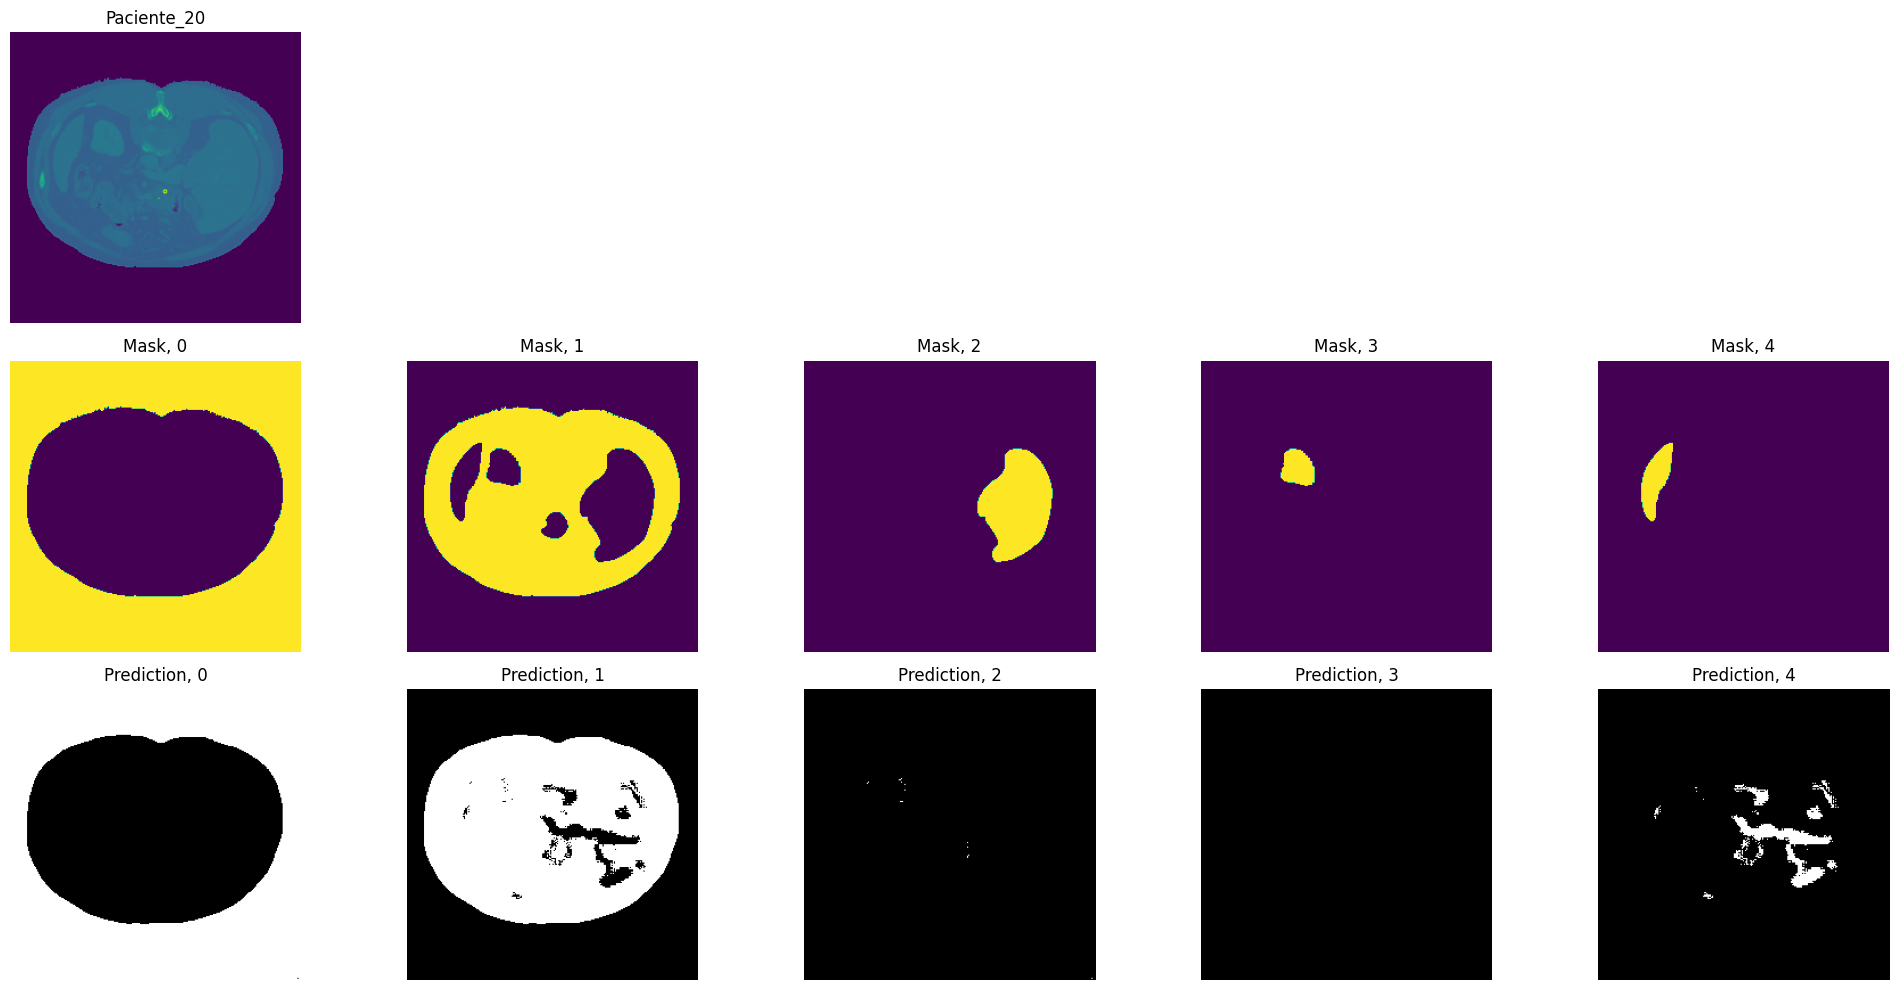

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


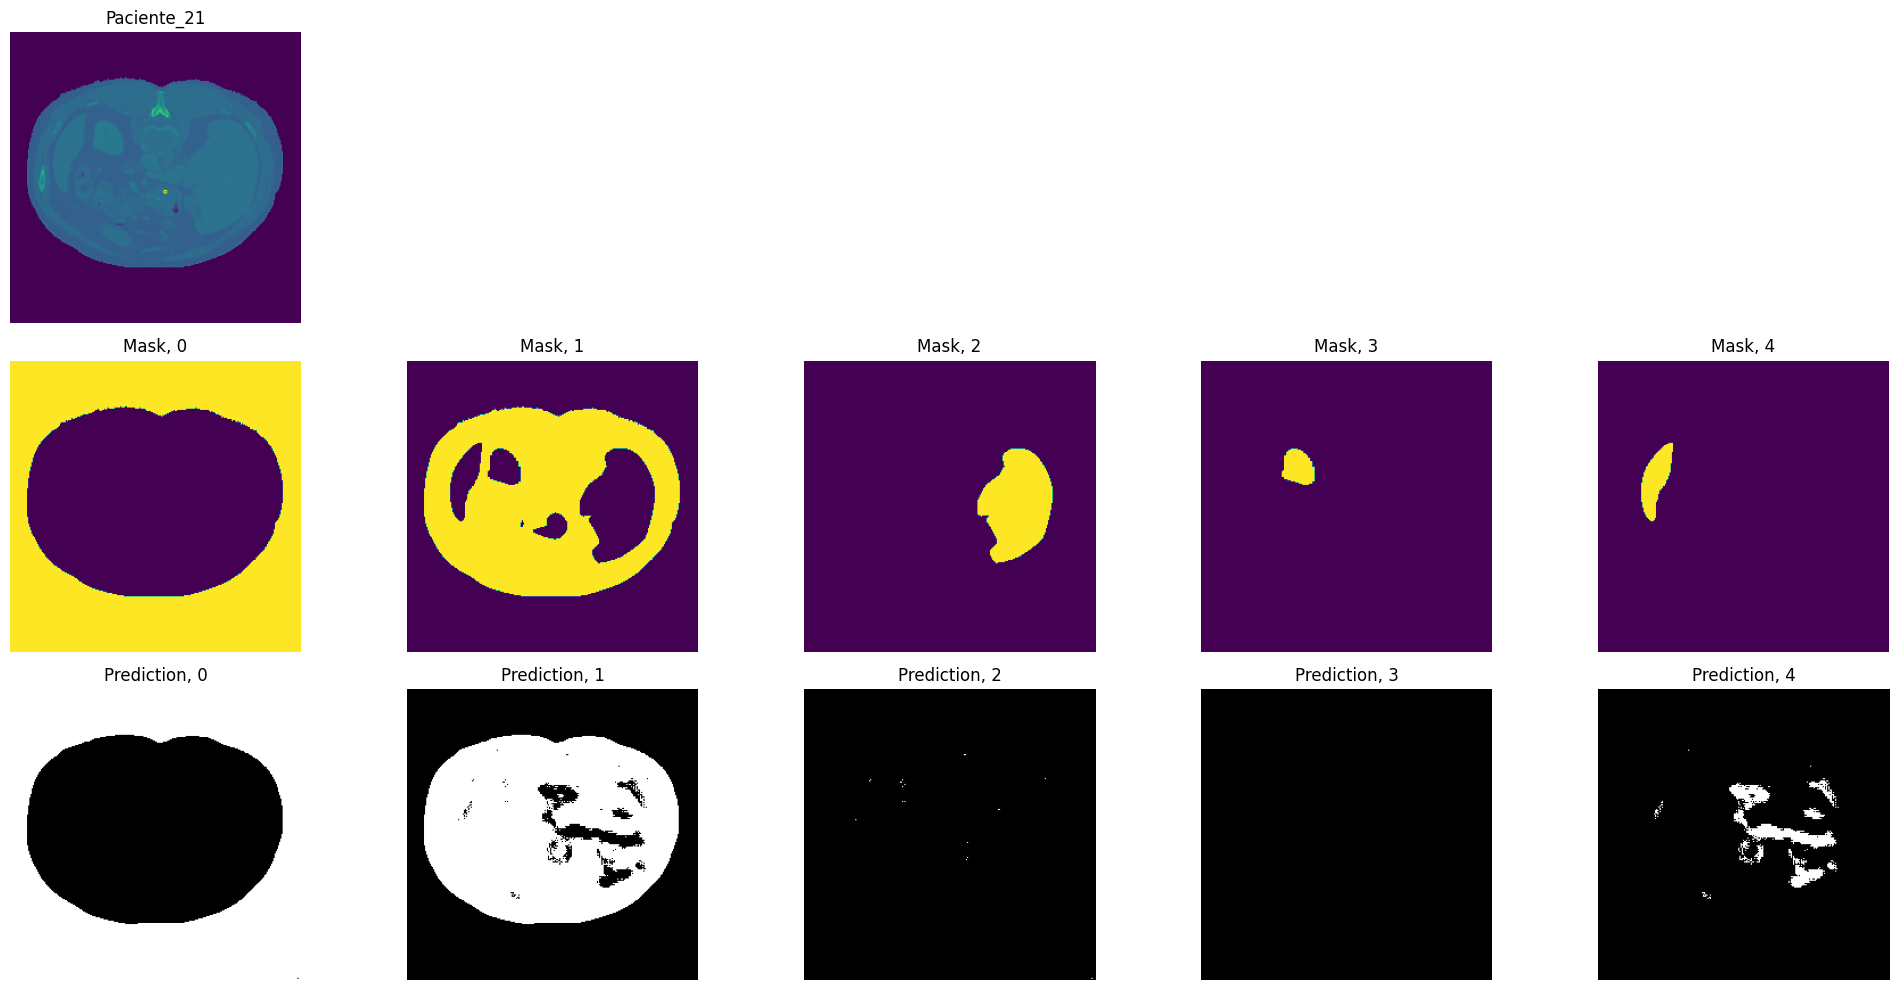

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


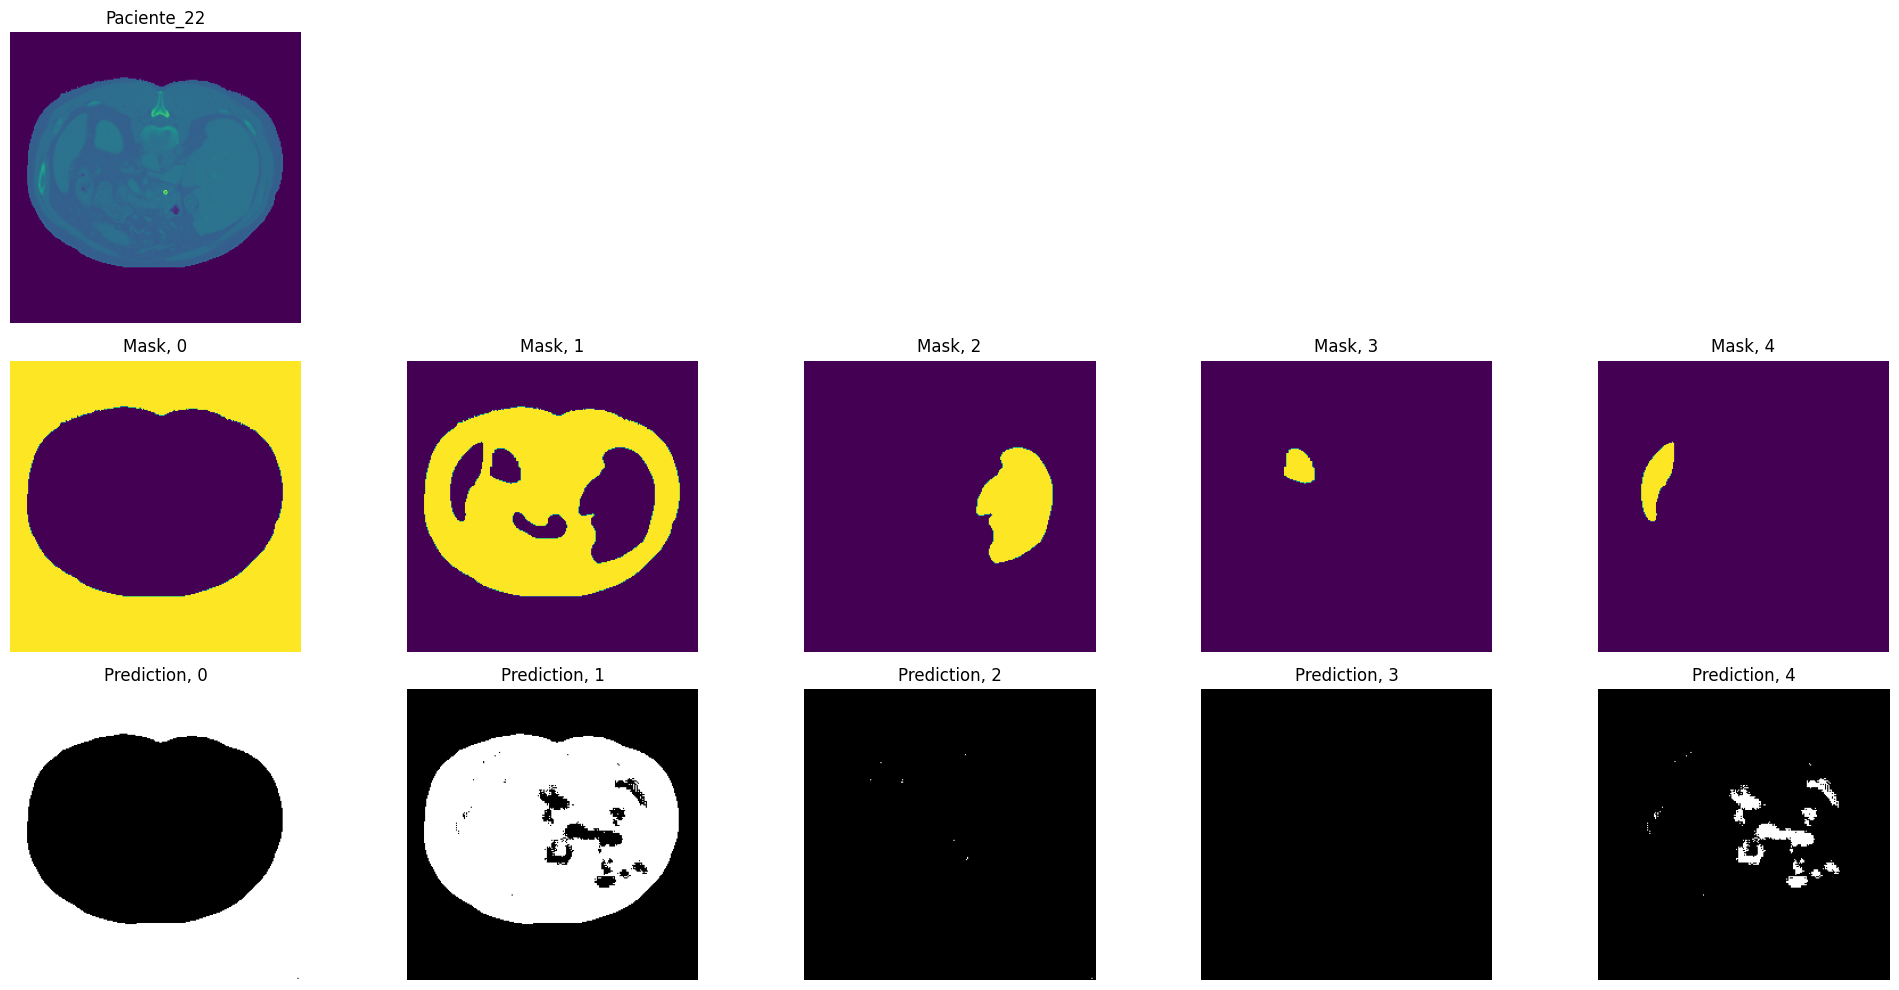

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


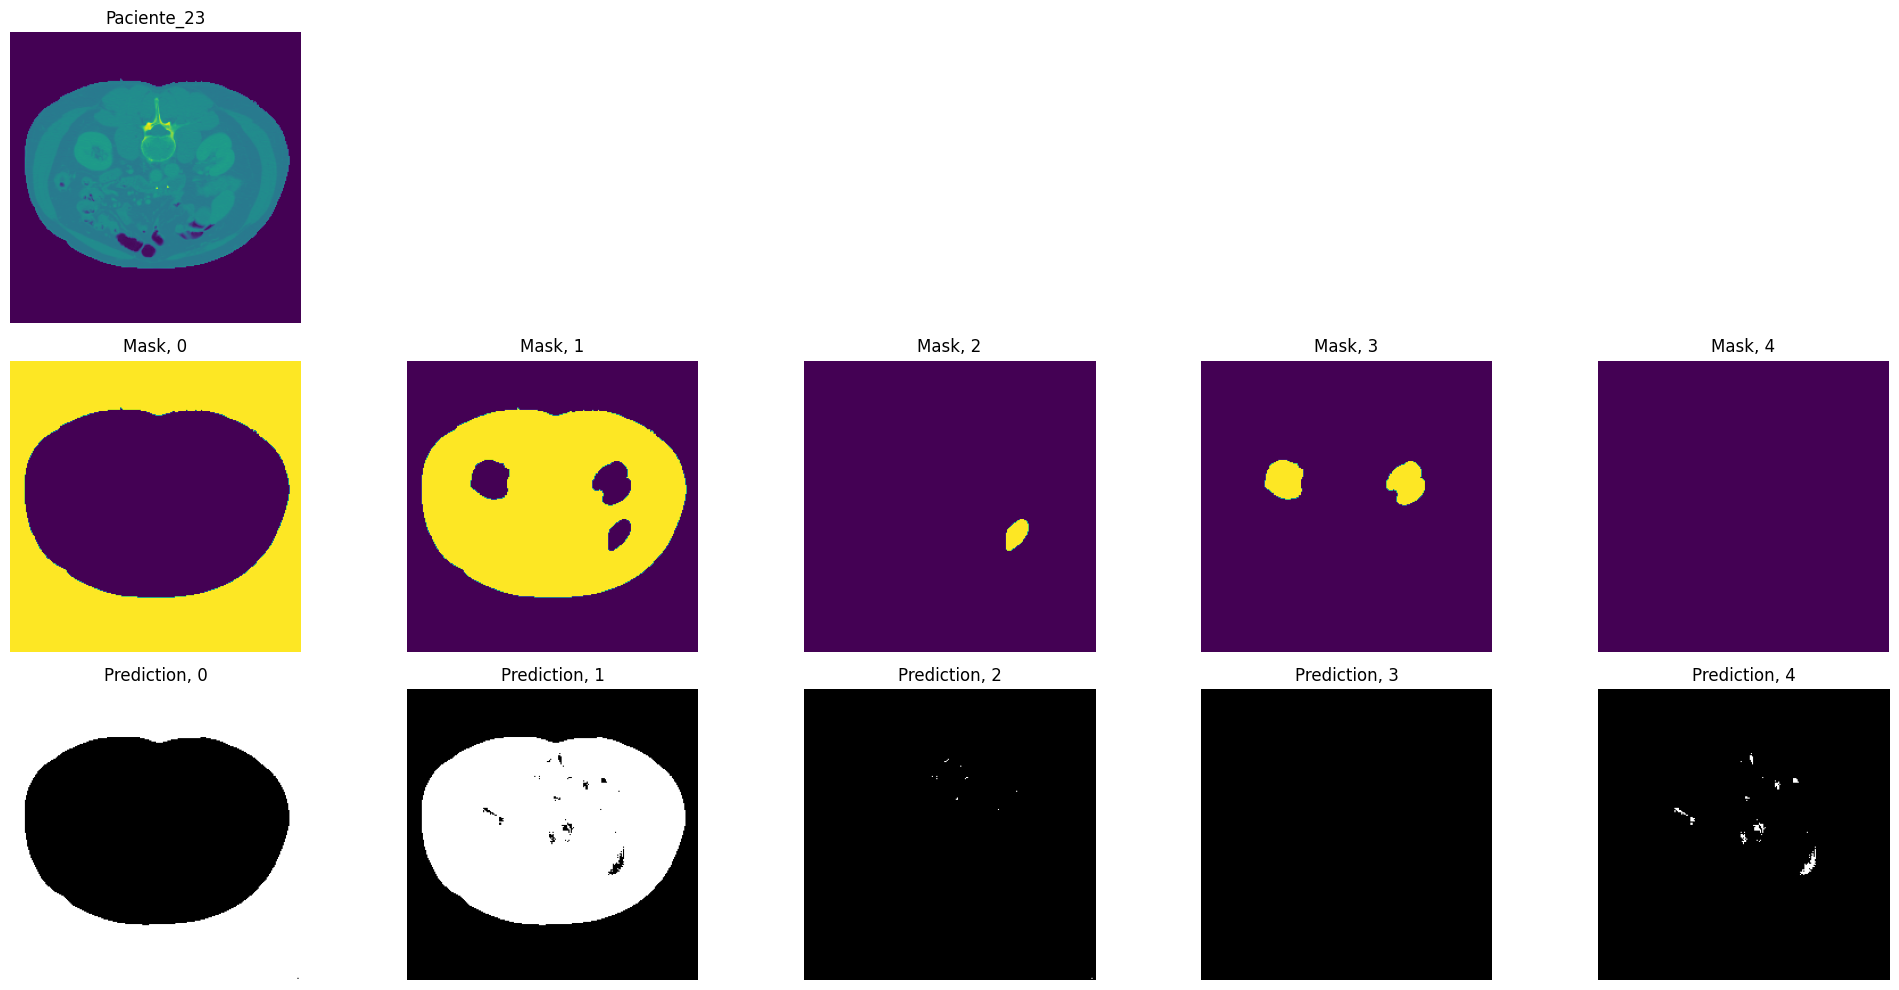

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


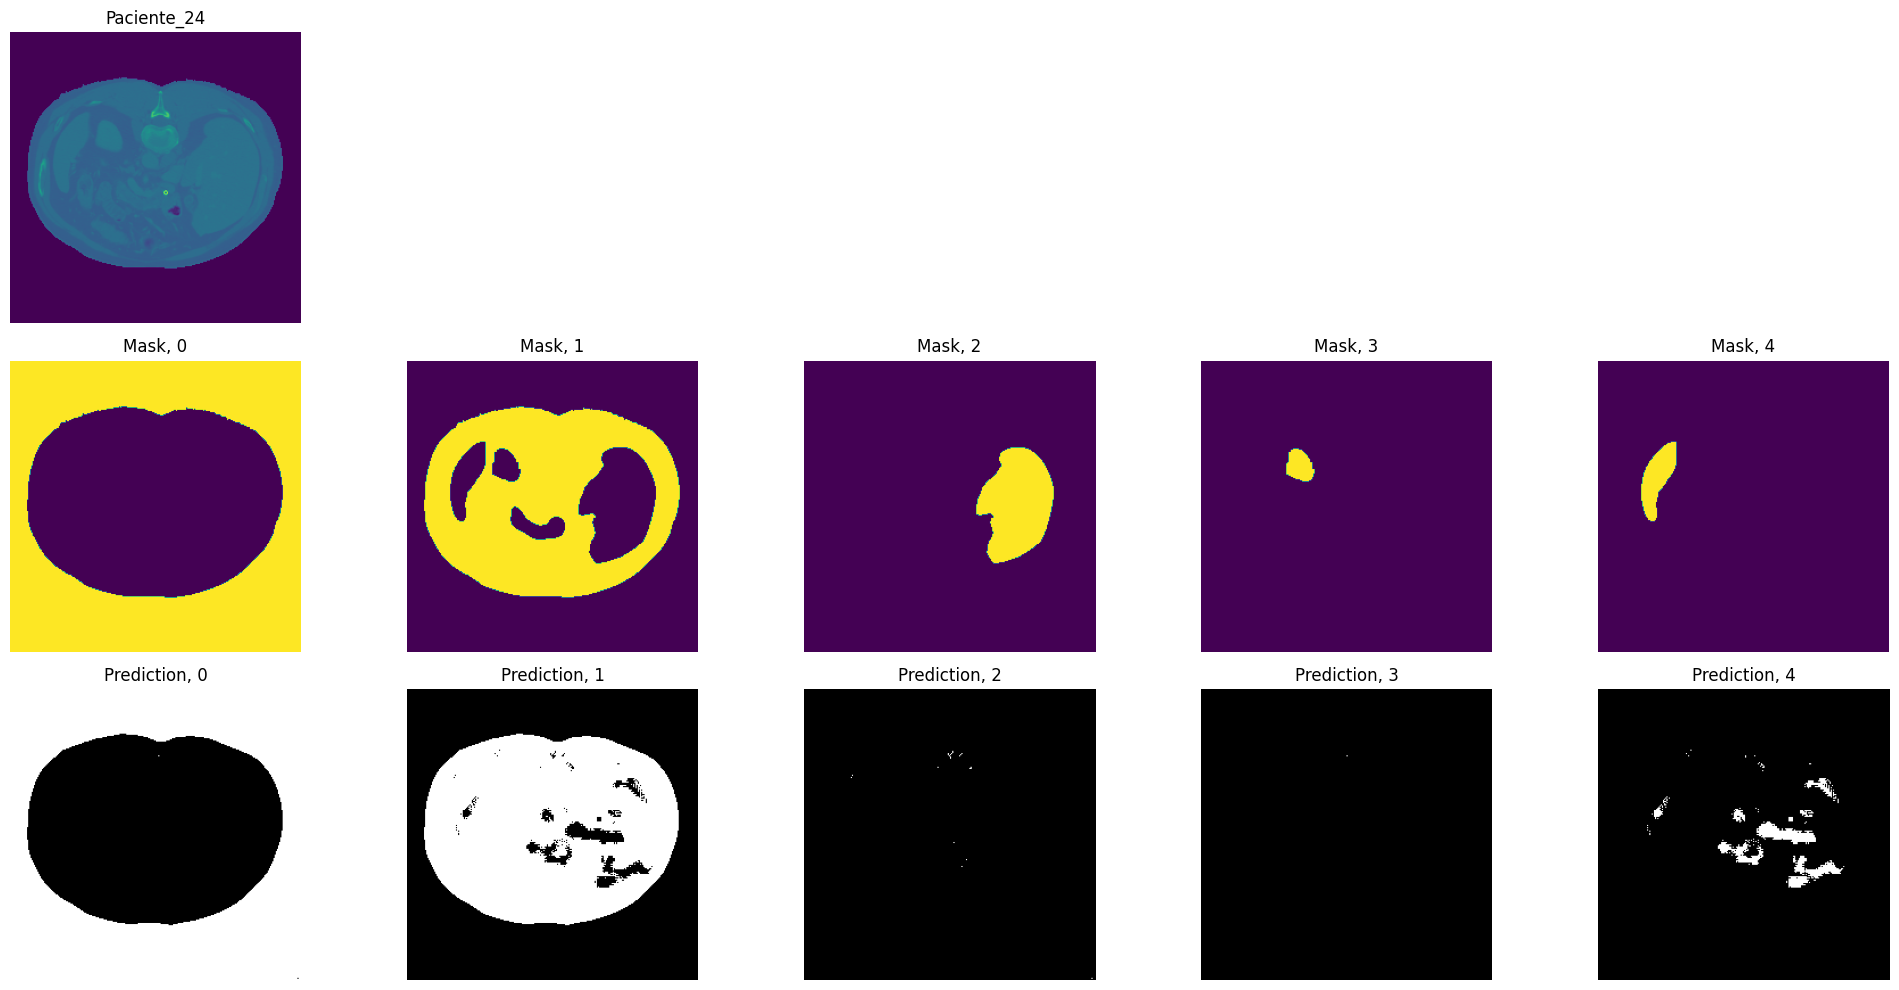

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


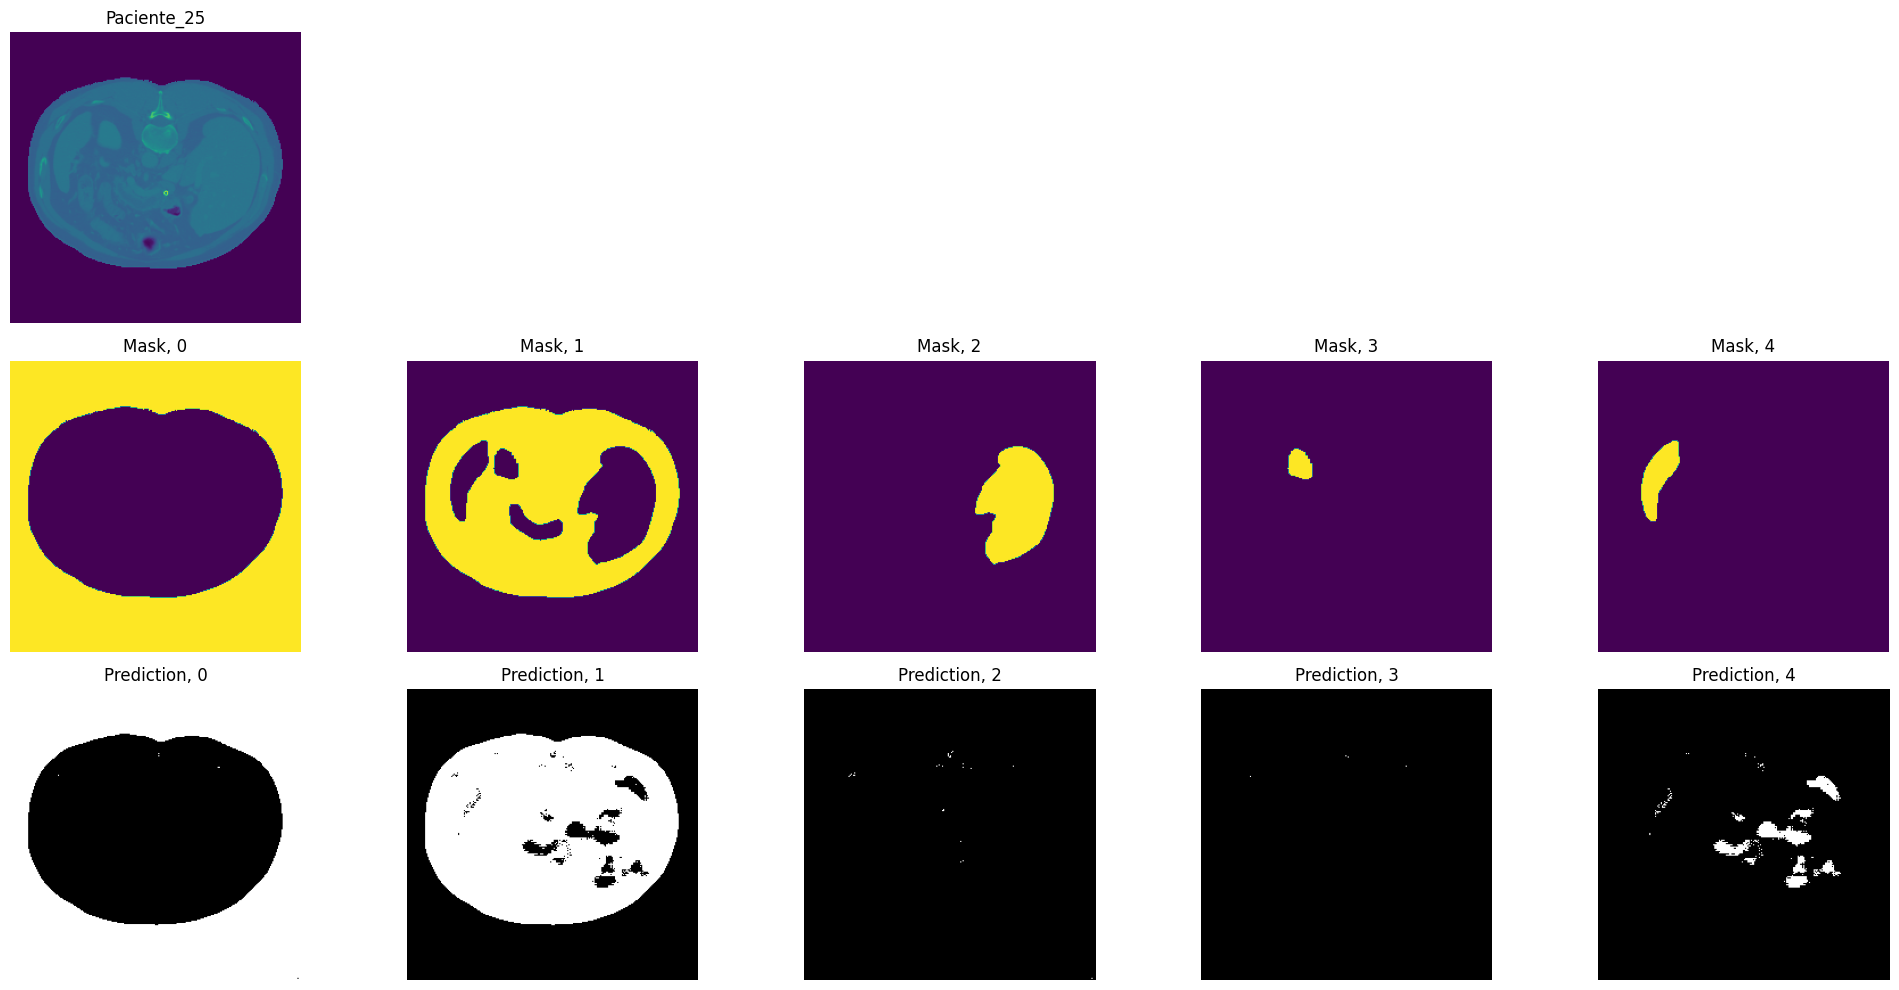

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


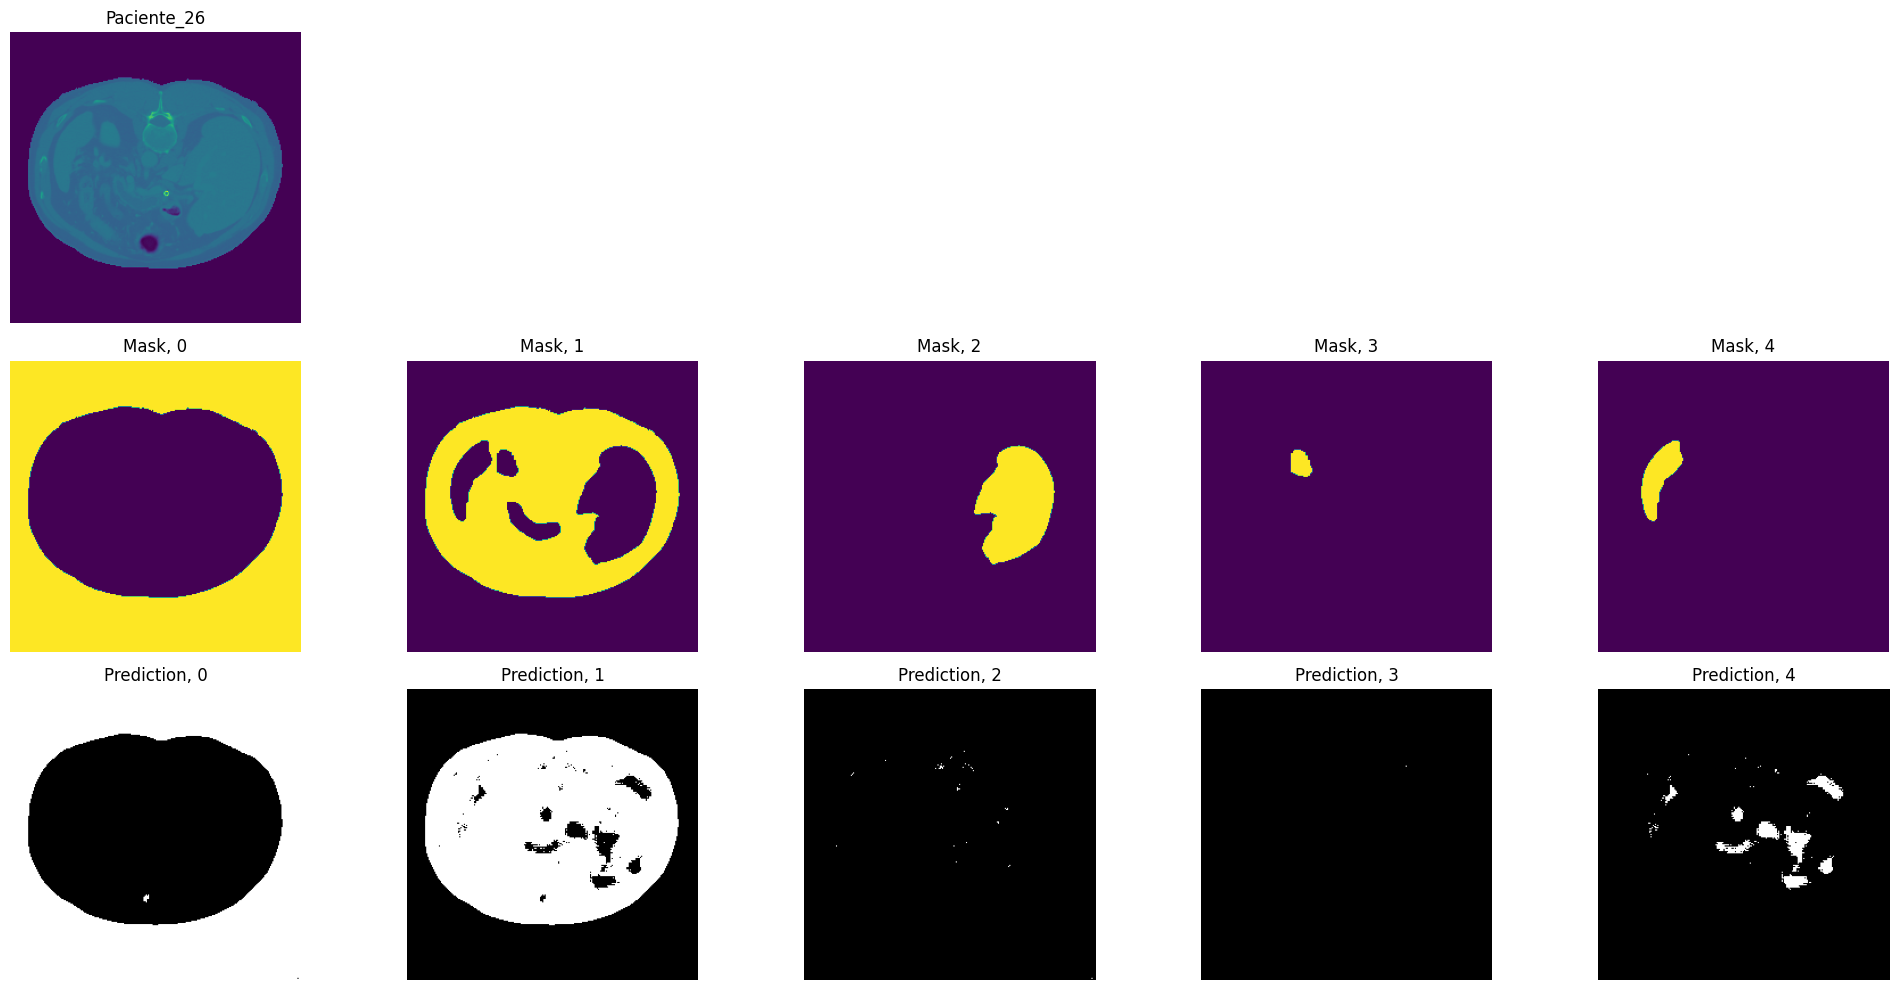

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


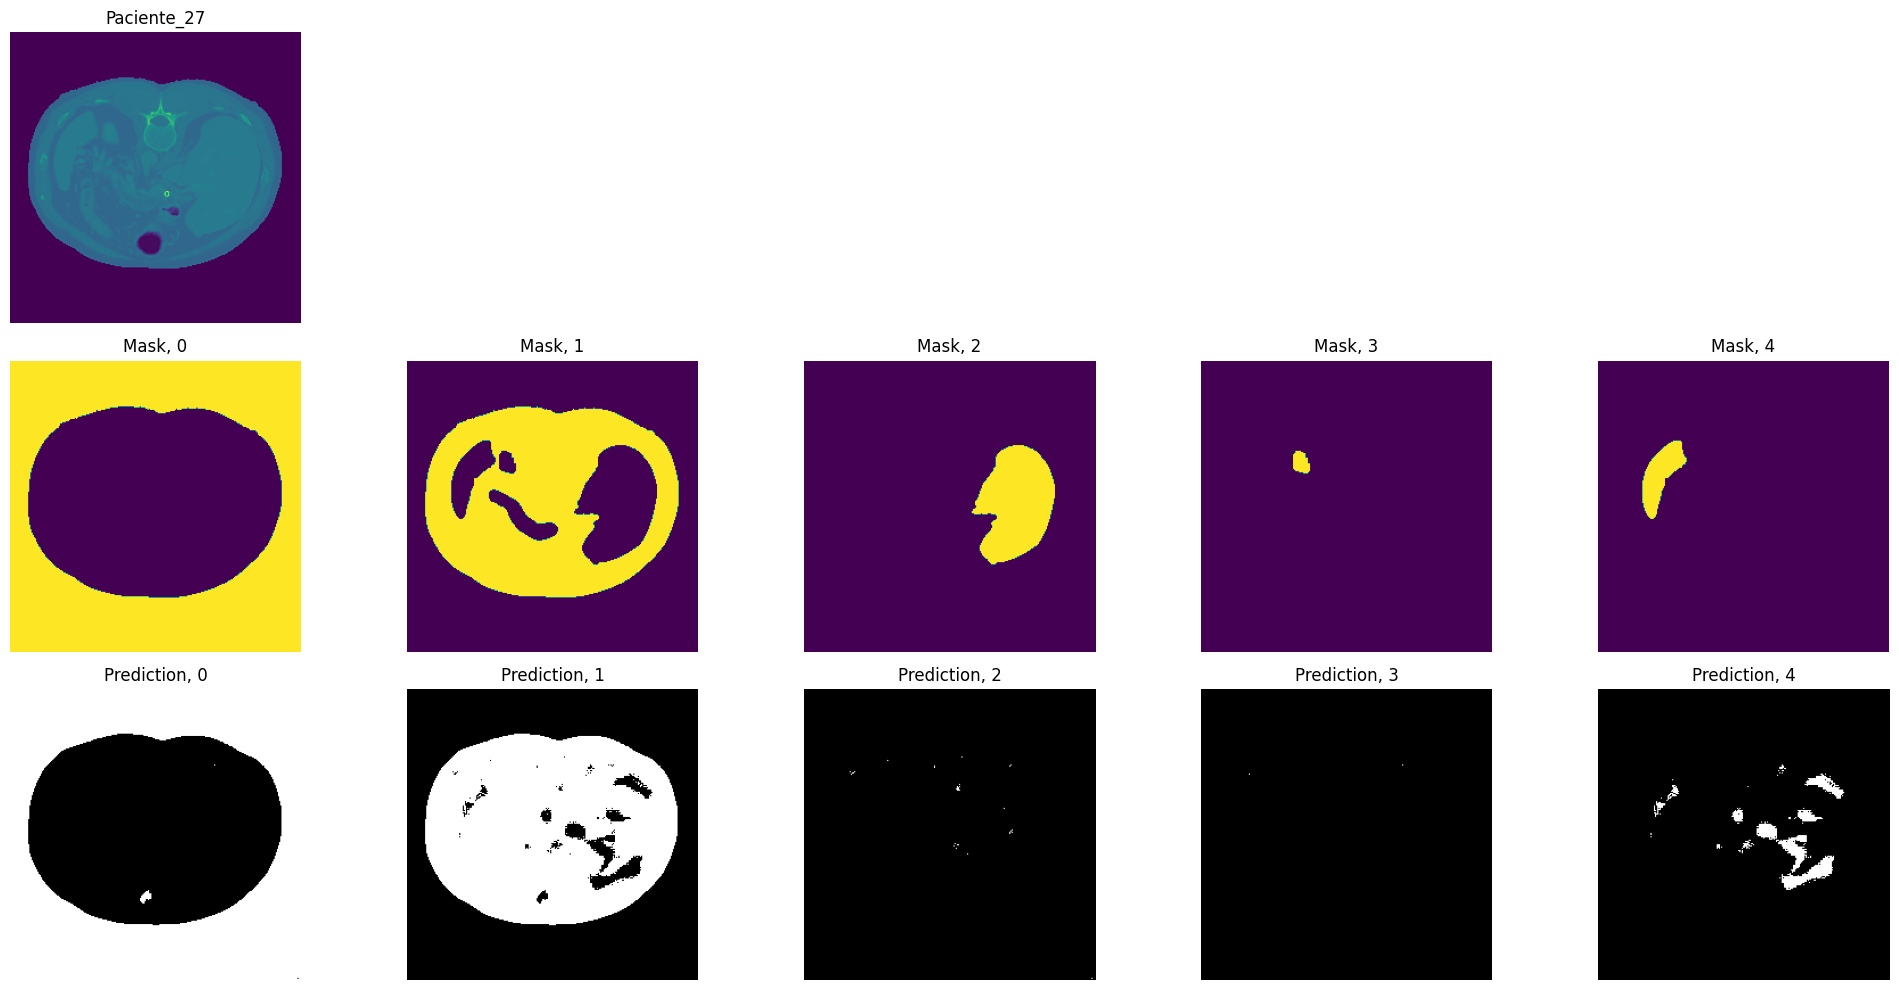

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


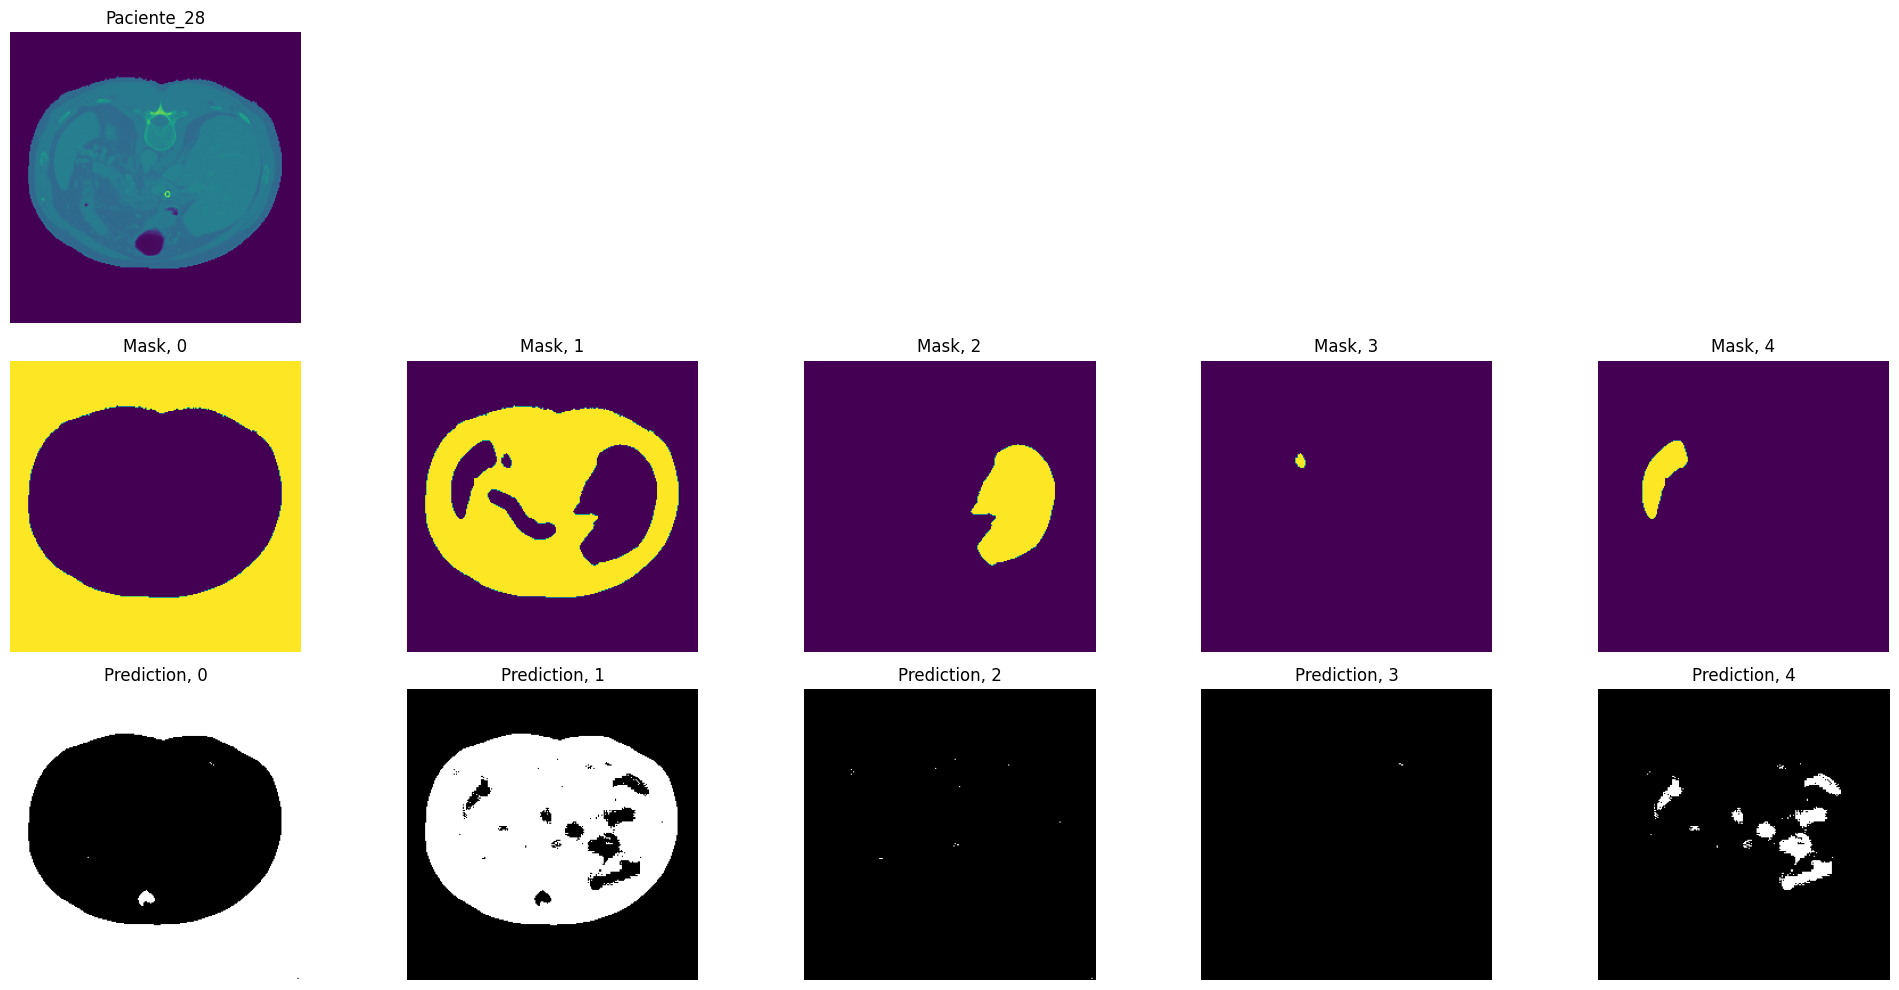

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


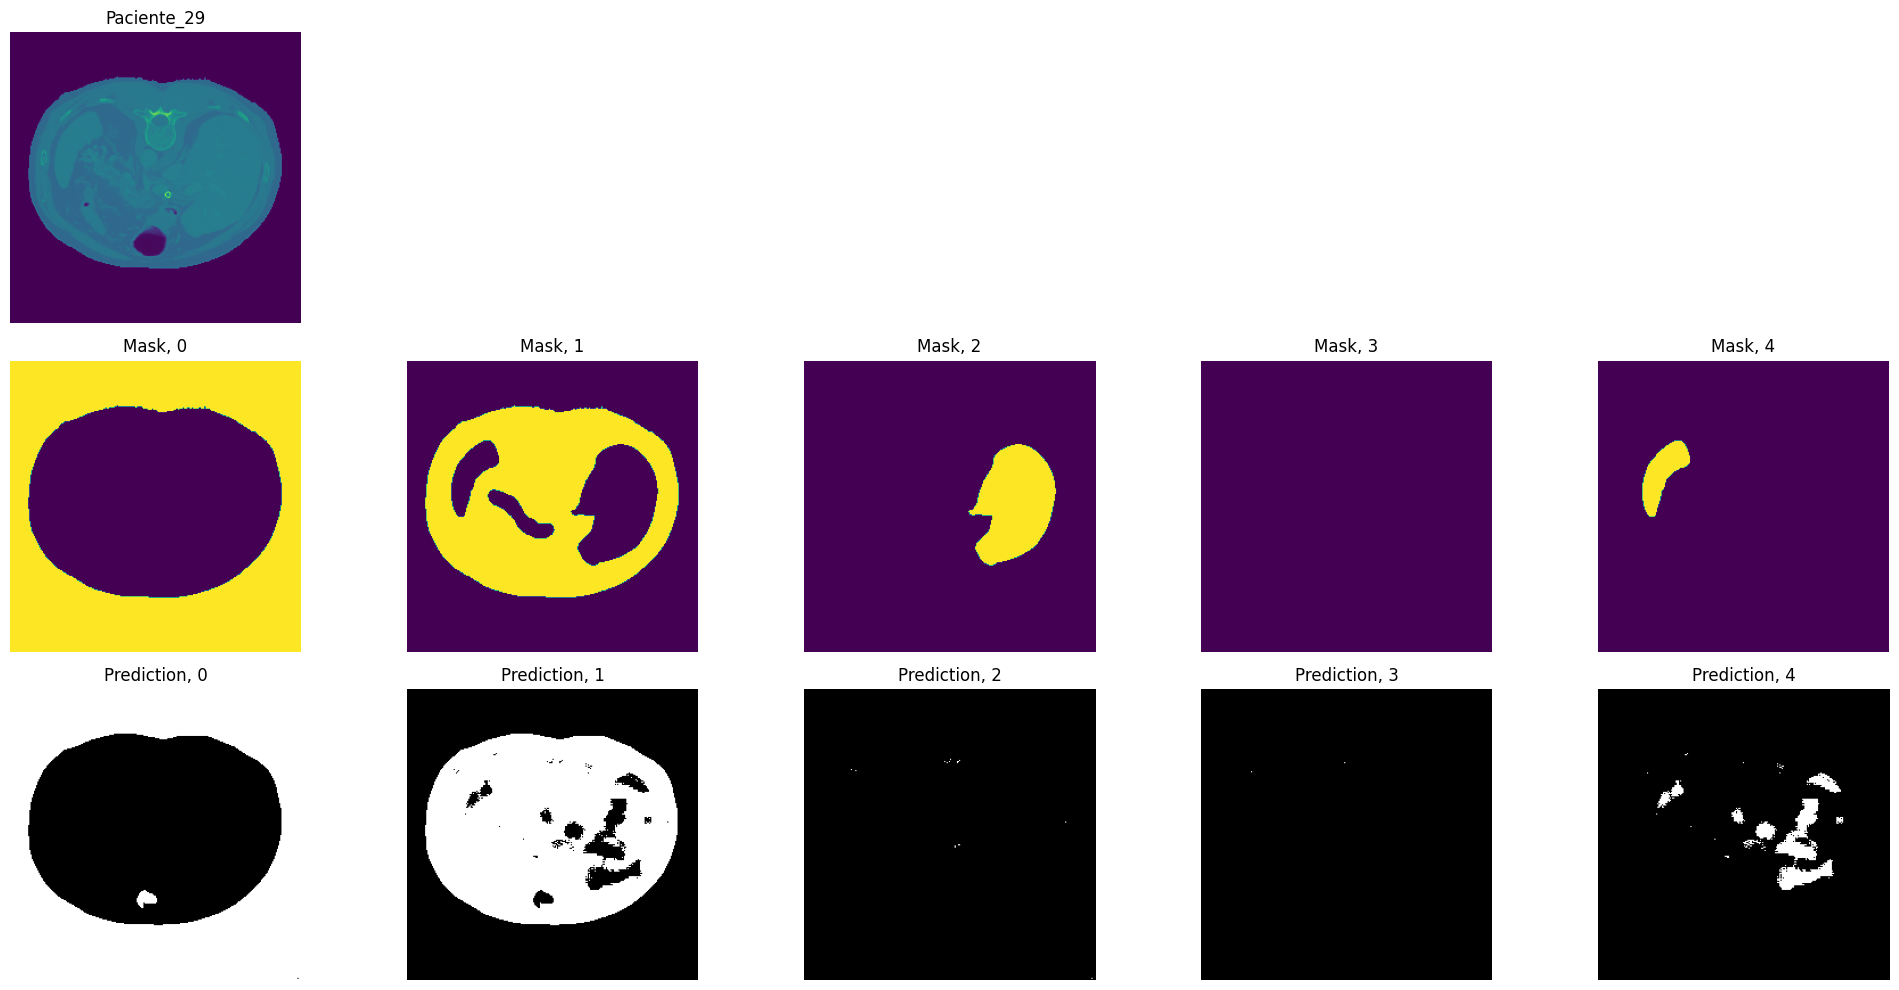

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


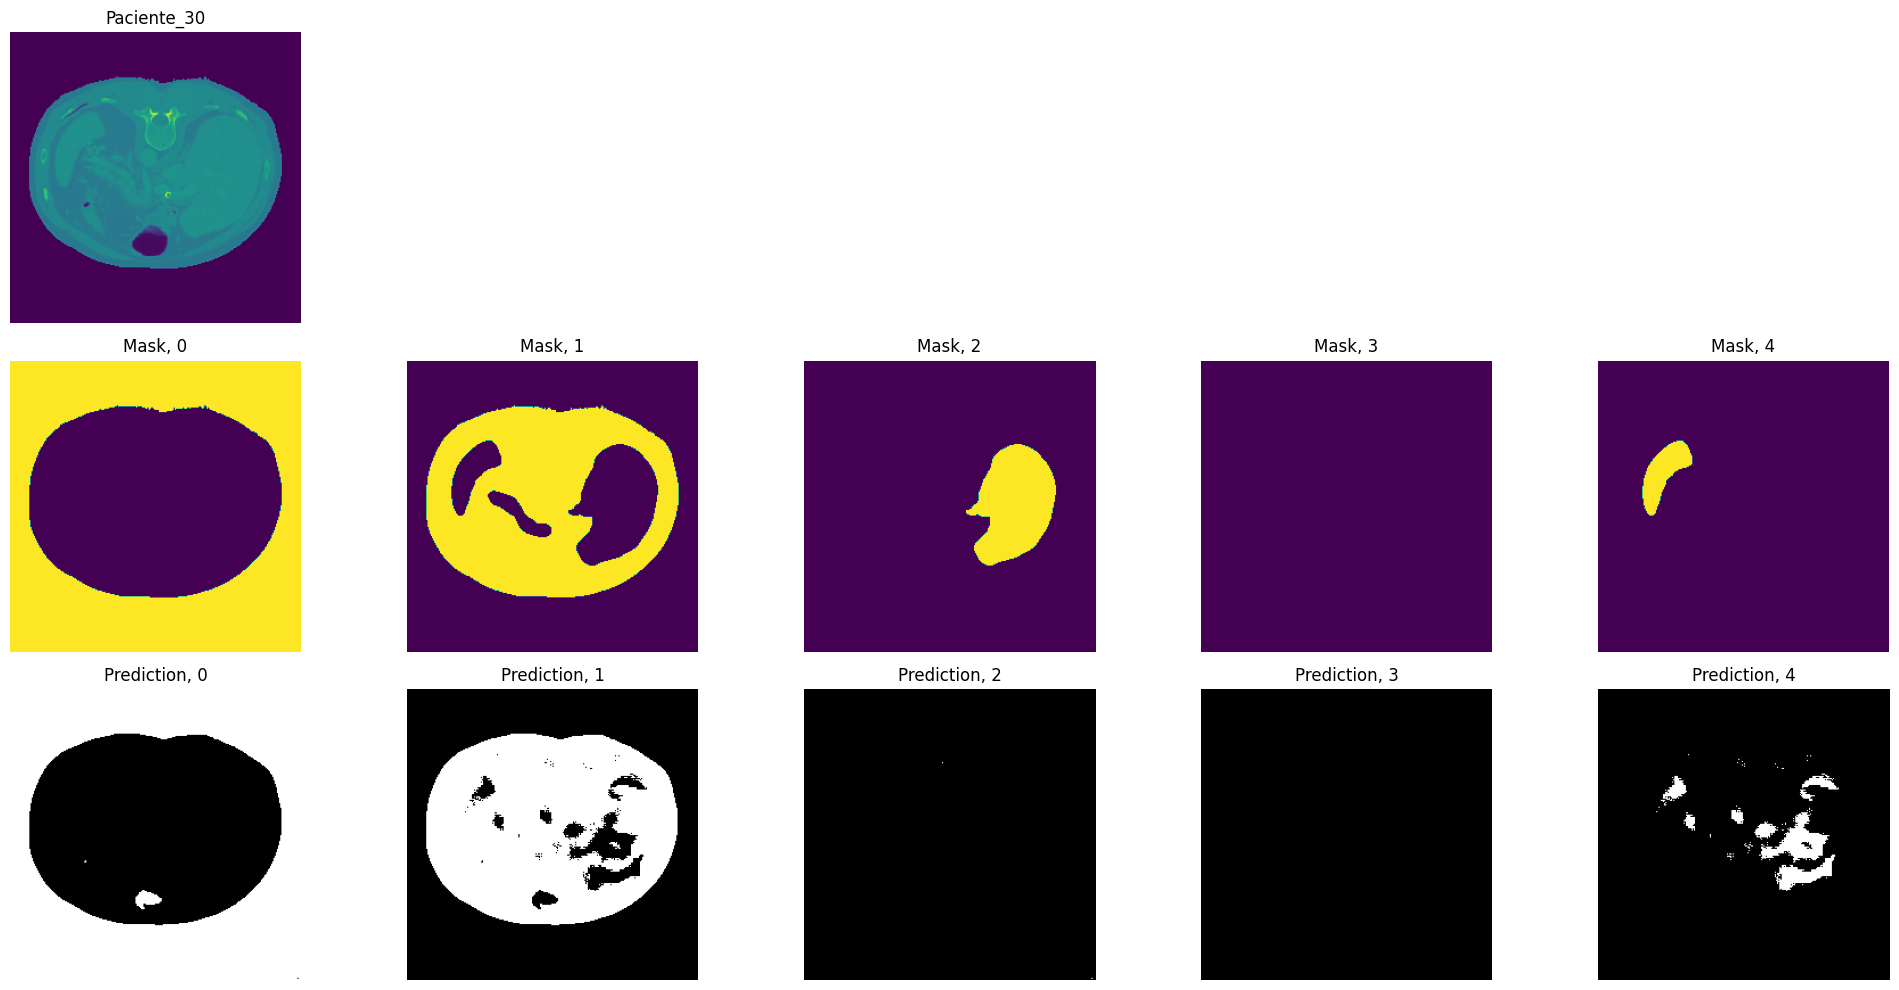

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


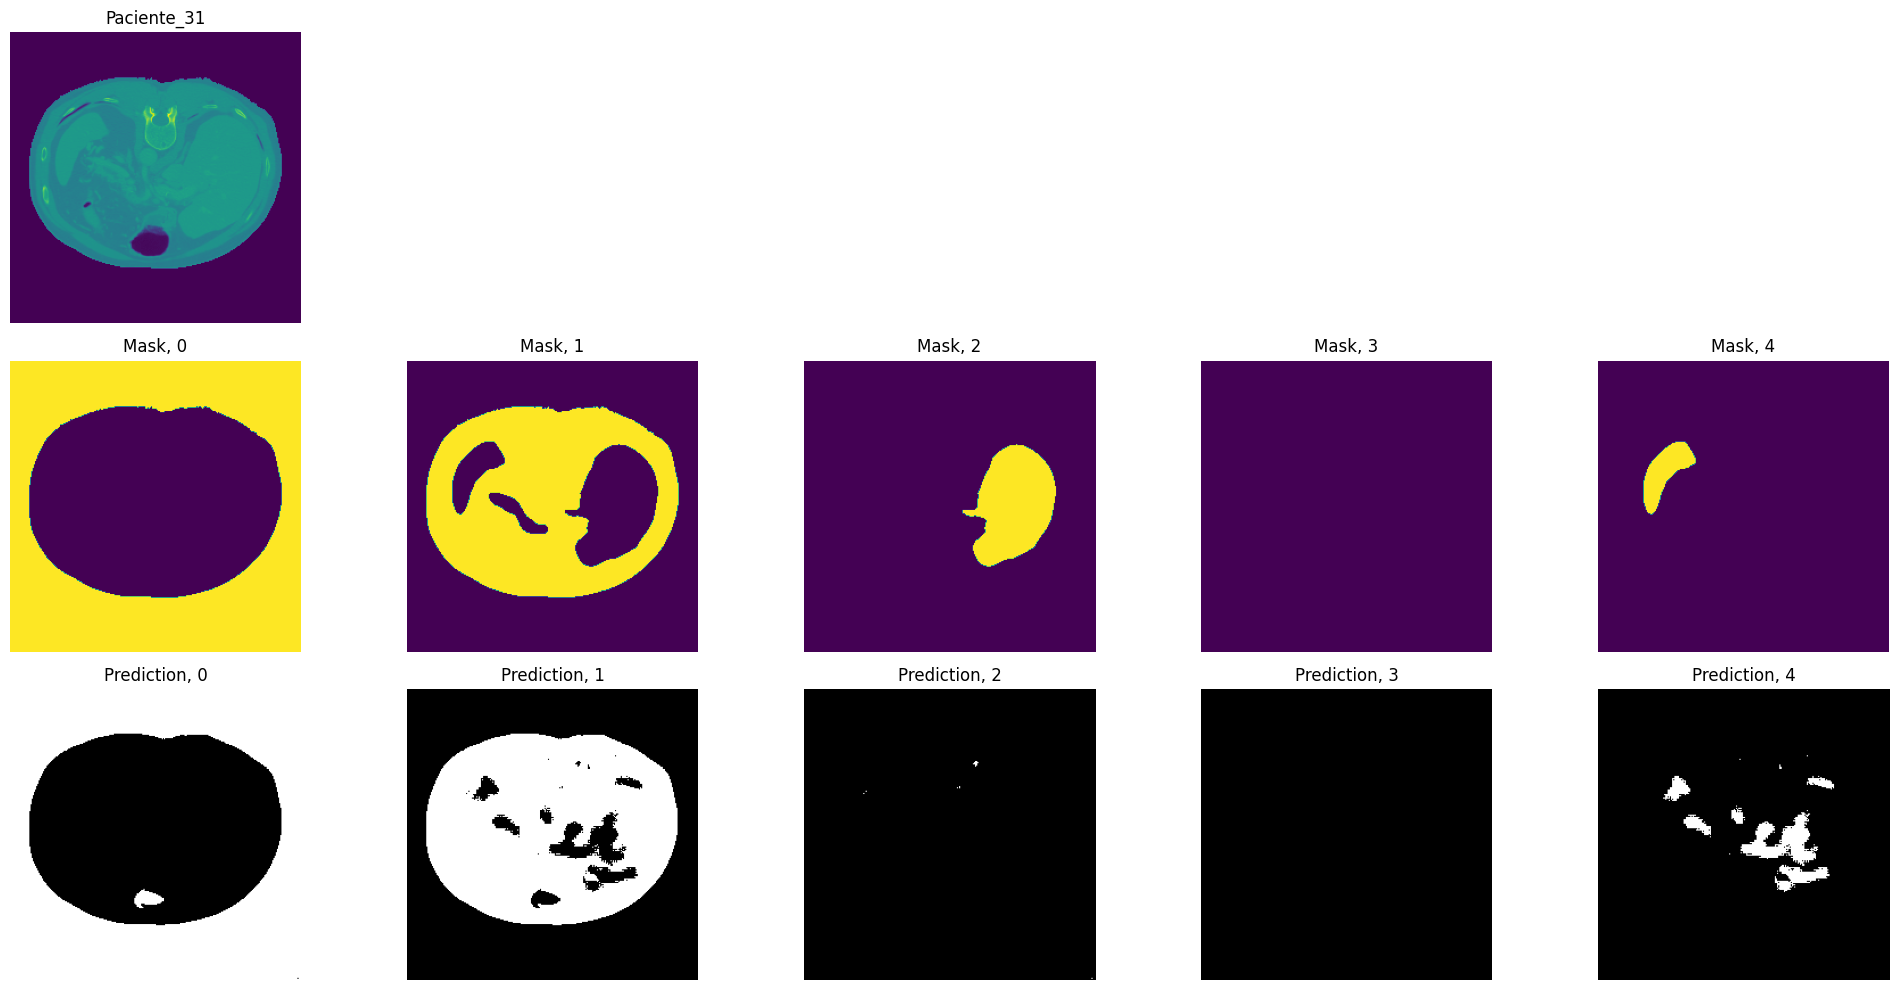

In [18]:
imageb, maskb = next(iter(valid_ds))

for i in range(len(imageb)):
    image, mask = imageb[i], maskb[i]

    pred = model.predict(image[tf.newaxis, ...])[0] # (height, width, n_classes) , in probabilities
    pred = tf.math.argmax(pred, axis=-1) # (height, width) , in classes [0, 1, 2, 3, 4,...]
    pred = tf.cast(tf.one_hot(pred, depth=n_classes), tf.int64) # (height, width, n_classes) , in one hot [0, 0, 0, 0, 1], [0, 1, 0, 0, 0] ...
    name = f"Paciente_{i}"
    plot_example(image, mask, pred,name)

In [19]:
# Extraer el historial de entrenamiento en un DataFrame
history_df = pd.DataFrame(history.history)

# Mostrar el DataFrame
print(history_df)

# Opcional: Guardar el DataFrame en un archivo CSV
history_df.to_csv('training_metrics.csv', index=False)

     accuracy  dice_score  f1-score  f2-score  iou_score      loss  precision  \
0    0.891500    0.439910  0.439910  0.440443   0.366657  0.331131   0.450637   
1    0.947234    0.552557  0.552557  0.552996   0.481754  0.146940   0.554607   
2    0.953363    0.584205  0.584205  0.584391   0.513091  0.122680   0.586235   
3    0.959840    0.634451  0.634451  0.635621   0.559402  0.097474   0.634921   
4    0.965019    0.675722  0.675722  0.677194   0.595336  0.083335   0.675974   
..        ...         ...       ...       ...        ...       ...        ...   
245  0.896230    0.421639  0.421639  0.423236   0.363672  0.278111   0.422848   
246  0.893306    0.420175  0.420175  0.421935   0.364081  0.283007   0.423509   
247  0.896444    0.421733  0.421733  0.423224   0.364390  0.275058   0.423351   
248  0.896914    0.420489  0.420489  0.421887   0.363035  0.278275   0.422129   
249  0.896277    0.420579  0.420579  0.422077   0.363962  0.277575   0.422864   

       recall  val_accuracy

In [20]:
def plot_training_history(history,name):
    """
    Plot the training and validation loss history using Plotly.

    Parameters:
    - history : dict
        A dictionary containing the history of the training and validation losses.
        Typically, this is `history.history` where `history` is the output from a
        training process in libraries like TensorFlow/Keras.

    Returns:
    - A Plotly figure object that can be displayed with `fig.show()`.
    """

    train_loss = history['loss']
    val_loss = history['val_loss']

    train_trace = go.Scatter(
        x=list(range(len(train_loss))),
        y=train_loss,
        mode='lines',
        name='Train Loss',
        line=dict(color='blue')
    )

    val_trace = go.Scatter(
        x=list(range(len(val_loss))),
        y=val_loss,
        mode='lines',
        name='Validation Loss',
        line=dict(color='red')
    )

    # Create layout
    layout = go.Layout(
        title=f'Función de Perdidas en Training y Test {name} - U-Net',
        xaxis=dict(title='Epochs'),
        yaxis=dict(title='Loss'),
        legend=dict(x=0.1, y=1.1, orientation='h')
    )

    # Create figure
    fig = go.Figure(data=[train_trace, val_trace], layout=layout)

    last_train_loss = train_loss[-1]
    last_val_loss   = val_loss[-1]
    fig.add_hline(y=last_train_loss, line_dash="dot", line_color="blue", annotation_text=f"Train Loss: {last_train_loss:.4f}",annotation_position="bottom right")
    fig.add_hline(y=last_val_loss, line_dash="dot", line_color="red", annotation_text=f"Validation Loss: {last_val_loss:.4f}",annotation_position="top right")
    # Adjust size and resolution
    fig.update_layout(width=640, height=480)  # equivalent to a 4x3 figure at 160 dpi
    fig.write_html(f"training_history_{name}.html")
    fig.show()

In [21]:
import plotly.graph_objects as go
import plotly.express as px
plot_training_history(history.history,'')

In [22]:
def plot_training_accuracy(history,name):
    """
    Plot the training and validation loss history using Plotly.

    Parameters:
    - history : dict
        A dictionary containing the history of the training and validation losses.
        Typically, this is `history.history` where `history` is the output from a
        training process in libraries like TensorFlow/Keras.

    Returns:
    - A Plotly figure object that can be displayed with `fig.show()`.
    """

    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    train_trace = go.Scatter(
        x=list(range(len(train_acc))),
        y=train_acc,
        mode='lines',
        name='Train Accuracy',
        line=dict(color='blue')
    )

    val_trace = go.Scatter(
        x=list(range(len(val_acc))),
        y=val_acc,
        mode='lines',
        name='Validation Accuracy',
        line=dict(color='red')
    )

    # Create layout
    layout = go.Layout(
        title=f'Accuracy en Training y Test {name} - U-Net',
        xaxis=dict(title='Epochs'),
        yaxis=dict(title='Loss'),
        legend=dict(x=0.1, y=1.1, orientation='h')
    )

    # Create figure
    fig = go.Figure(data=[train_trace, val_trace], layout=layout)

    last_train_loss = train_acc[-1]
    last_val_loss   = val_acc[-1]
    fig.add_hline(y=last_train_loss, line_dash="dot", line_color="blue", annotation_text=f"Train Accu: {last_train_loss:.4f}",annotation_position="bottom right")
    fig.add_hline(y=last_val_loss, line_dash="dot", line_color="red", annotation_text=f"Validation Accu: {last_val_loss:.4f}",annotation_position="top right")
    # Adjust size and resolution
    fig.update_layout(width=640, height=480)  # equivalent to a 4x3 figure at 160 dpi
    fig.write_html(f"history_Accuracy_{name}.html")
    fig.show()

In [23]:
plot_training_accuracy(history.history,'')